## Ce notebook contient 2 parties
* ### Une première partie pour l'analyse et le nettoyage
* ### Une seconde pour la modélisation

### Rappel problématique 
* Pour accorder ou non un crédit à la consommation, l’entreprise "Prêt à dépenser" calcule la probabilité qu’un client le rembourse, ou non. Elle souhaite donc développer un algorithme de scoring pour aider à décider si un prêt peut être accordé à un client.

* Les chargés de relation client seront les utilisateurs du modèle de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client



# Structure du notebook

### Table of Contents

* [Importation et chargement des données](#chapter1)
    * [Description fonctionnelle des fichiers et MCD](#section_1_1)
    * [Analyse de l'ensemble des fichiers du projet](#section_1_2)
        * [Choix des fichiers pertinents ](#section_1_2_1)
* [I - Analyse et nettoyage des fichiers de crédit](#chapter2)
    * [Visualisation des données des fichiers de crédit](#section_2_1)
    * [Comparaison de la structure des 2 fichiers de crédit Train & Test](#section_2_2)
    * [Analyse des données manquantes - dataframe de crédit](#section_2_3)
    * [Création d'un dataframe spécifique aux données manquantes](#section_2_4)
    * [Analyse des colonnes 'object'](#section_2_5)
    * [Les descriptions des colonnes 'object' - extrait du dataframe "description_files"](#section_2_6)    
   
* [Analyse univariée et multivariée](#chapter3)
    * [Statistique sur  les colonnes object](#section_3_1)
    * [Statistique sur les données numériques](#section_3_2) 
    * [Affichages des libellés descriptions des rubriques numériques](#section_3_3)
    * [Affichage courbe densité des données numériques](#section_3_4)

* [Transformation des dataframes pour la modélisation](#chapter4)
    * [Encodage de nos données features "Object"](#section_4_1)
    * [get dummies et encodage à un coup](#section_4_2)
    * [Mise en cohérence des dataframes app_train et app_test après "get_dummies"](#section_4_3)
    * [Travail sur les périodes importantes (durée en jours)](#section_4_4) 
         * [Age en année](#section_4_4_1)
         * [Nombre de jours dans le dernier emploi](#section_4_4_2)  
    * [Afficher graphique des corrélations](#section_4_5)
    * [Les corrélations les plus fortes concernent les données concernant les buildings dans le détail](#section_4_6)
    * [Traitement des données manquantes avec suppression des colonnes liées aux "building"](#section_4_7) 
    * [Zoom sur la rubrique AGE](#section_4_8) 
    * [Corrélation entre la cible, les notations extérieures et la naissance](#section_4_9) 
    * [Graphique cible, les notations extérieures et la naissance](#section_4_10) 
* [Seconde partie - MODELISATION DU RISQUE METIER](#chapter5)
    * [Création du jeu de données avec données du dataframe 'training'](#section_5_1)
    * [Création des  modéles](#section_5_2)
         * [Modèle LogisticRegression](#section_5_2_1)  
         * [DecisionTreeClassifier](#section_5_2_2) 
         * [Random Forest](#section_5_2_3)
         * [XG Boost Classifier](#section_5_2_4)
         * [Lightbgm](#section_5_2_5)
* [scoring_1 Modèle brut avec dataframe "training"](#chapter6)
* [scoring_2 - Modèles avec grille de paramètres sur jeu de training](#chapter7)
* [scoring_3 - Modèles avec grille de paramètre avec jeu de training et undersampling](#chapter8)
    * [Validation et choix des 2 meilleurs modèles](#section_8_1)

* [Création de 2 dataframes spécifique domain](#chapter9)
    * [Feature Engineering](#section_9_1)
* [Création des dataframes Train et Test après normalisation des données](#chapter10)
    * [# Normalisation des données dataframes domaines pour le déploiement](#section_10_1)
   
* [Modélisation DataFrame Domain](#chapter11)
    * [scoring_4 - 2 meilleurs modèles avec grille de paramètre avec jeu de training (DataFrame training) sur Dataframe domain et undersampling](#section_11_1)
* [Création metric client & des 2 meilleurs modèles](#chapter12) 
    * [Scoring 5 - metric client & 2 meilleurs modèles](#section_12_1)
        * [Scoring 5 avec xgb_fbetascore (xgb = XGBClassifier)](#section_12_1_1)
        * [Matrice de confusion (xgb = XGBClassifier)](#section_12_1_2)
        * [Scoring 5 avec lightgbm_fbetascore](#section_12_1_3)
    * [Affichage des features importantes](#section_12_2)        
* [Sauvegarde du modèle Lightgbm](#chapter13)
* [shap](#chapter14)
    * [shap et lightgbm](#section_14_1)   

# Importation et chargement des données <a class="anchor" id="chapter1"></a>

In [1]:
# importation des librairies nécéssaire dans l'analyse de cette expérience
import matplotlib
import matplotlib.pyplot as plt # pour les graphique  classique
import seaborn as sns
import numpy as np
import pandas as pd # pour le dataframe du jeu de données pour une gestion plus facile
%pwd # pour savoir l'emplacement de mes données

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import time
from time import strftime
from datetime import datetime

#Normalisation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
#Model
from xgboost import XGBClassifier
import lightgbm as lgb

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import classification_report_imbalanced

#Sauvegardes diverses dataframe domain
import pickle
import joblib

In [2]:
pd.set_option("display.max_rows", 300) 
pd.set_option("display.max_info_columns",300)
pd.set_option("display.max_columns", 300) 
pd.set_option("display.max_info_rows",300)

In [19]:
def affiche_temps(): 
    now = datetime.now() # current date and time

    year = now.strftime("%Y")
    month = now.strftime("%m")
    day = now.strftime("%d")
    time = now.strftime("%H:%M:%S")
    date_time = now.strftime("%d/%m/%Y, %H:%M:%S")
    return date_time

In [3]:
chemin_fichier="C:/Users/User/Documents/OpenClassroom/Projet7/Data/Projet_Mise_en_prod_home_credit_default_risk"
chemin_graph="C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/"

### Description fonctionnelle des fichiers et MCD <a class="anchor" id="section_1_1"></a>
* Reprise du site fournisseur de données
* Traduite en français après vérification par mes soins pour une compréhension plus rapide et claire

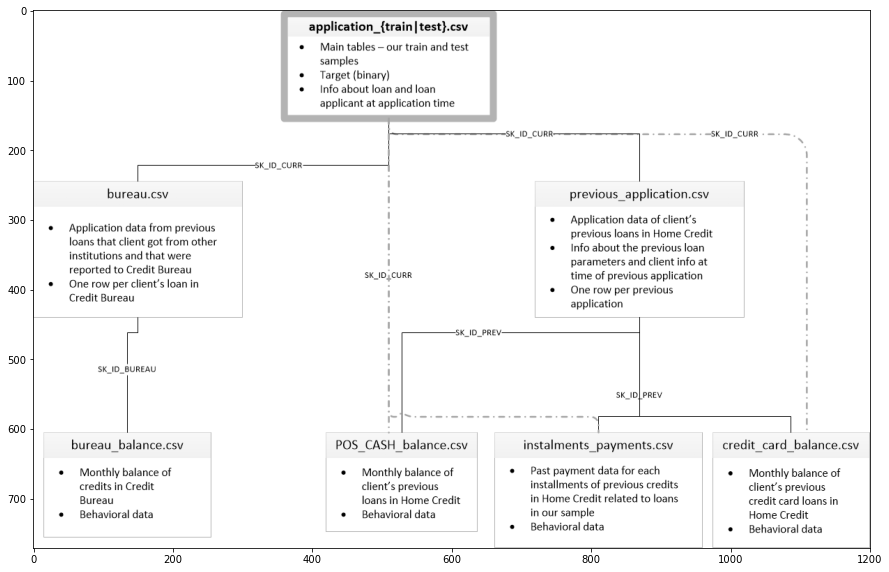

In [5]:
# 2ème exécution inutile (invariant)
plt.figure(figsize=(15,10))
image=plt.imread(chemin_graph+"P7_MCD_home_credit.png")
plt.imshow(image)

### application_{train|test}.csv

*    Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
*    Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

###### bureau.csv

*     Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau (pour les clients qui ont un prêt dans notre échantillon).
*    Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

###### bureau_balance.csv

*    Soldes mensuels des crédits précédents dans Credit Bureau.
*    Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) des lignes.

### previous_application.csv

* Toutes les demandes précédentes de crédit immobilier des clients qui ont des prêts dans notre échantillon.
* Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.


###### POS_CASH_balance.csv

* Des instantanés des soldes mensuels des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit.
* Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent au Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes.
   
###### credit_card_balance.csv

* Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit.
* Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans le Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

###### installments_payments.csv

* Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon.
* Il y a :
** a) une ligne pour chaque paiement qui a été effectué plus 
** b) une ligne pour chaque paiement manqué.
* Une ligne équivaut à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon.

###### HomeCredit_columns_description.csv

* Ce fichier contient les descriptions des colonnes des différents fichiers de données. Ex:

** ID of loan in our sample 
** Identification if loan is cash or revolving 
** Gender of the client 
** Flag if the client owns a car

##### sample_submission.csv
* pas de description particulière

## Analyse globale de l'ensemble des fichiers du projet <a class="anchor" id="section_1_2"></a>
1. application_train.csv
2. application_test.csv
3. bureau.csv
4. bureau_balance.csv
5. previous_application.csv
6. installments_payments.csv
7. credit_card_balance.csv
8. POS_CASH_balance.csv
9. HomeCredit_columns_description.csv
10. sample_submission.csv

In [4]:
# A exécuter
dict_df={'application_train': ['application_train'],
         'application_test': ['application_test'],
         'bureau': ['bureau'],
         'bureau_balance': ['bureau_balance'],
         'previous_application': ['previous_application'],
         'installments_payments': ['installments_payments'],
         'credit_card_balance': ['credit_card_balance'],
         'POS_CASH_balance': ['POS_CASH_balance'],
         'HomeCredit_columns_description': ['HomeCredit_columns_description'],
         'sample_submission': ['sample_submission']}

In [5]:
# A exécuter 
app_train = pd.read_csv(chemin_fichier+"/application_train.csv", sep=",")
dict_df['application_train'].append(app_train)
app_test = pd.read_csv(chemin_fichier+"/application_test.csv", sep=",")
dict_df['application_test'].append(app_test)
bureau = pd.read_csv(chemin_fichier+"/bureau.csv", sep=",")
dict_df['bureau'].append(bureau)
bureau_balance = pd.read_csv(chemin_fichier+"/bureau_balance.csv", sep=",")
dict_df['bureau_balance'].append(bureau_balance)
prev_app = pd.read_csv(chemin_fichier+"/previous_application.csv", sep=",")
dict_df['previous_application'].append(prev_app)
install_pay = pd.read_csv(chemin_fichier+"/installments_payments.csv", sep=",")
dict_df['installments_payments'].append(install_pay)
cc_balance = pd.read_csv(chemin_fichier+"/credit_card_balance.csv", sep=",")
dict_df['credit_card_balance'].append(cc_balance)
cash_balance = pd.read_csv(chemin_fichier+"/POS_CASH_balance.csv", sep=",")
dict_df['POS_CASH_balance'].append(cash_balance)
description_files = pd.read_csv(chemin_fichier+"/HomeCredit_columns_description.csv", sep=",")
dict_df['HomeCredit_columns_description'].append(description_files)
sample_submission = pd.read_csv(chemin_fichier+"/sample_submission.csv", sep=",")
dict_df['sample_submission'].append(sample_submission)

In [6]:
# A exécuter (optionnel)
for i in dict_df:  
    print("-------------------------------------")
    print("! Nom du Dataframe : ", dict_df[i][0], "!")
    print("------------------------------------")
    print(dict_df[i][1].info(verbose=True, buf=None, max_cols=None, memory_usage=None, show_counts=True, null_counts=None))
    print("------------ Description courte --------------")
    print(dict_df[i][1].head(5))
    print("------------ Taille --------------")
    print("----> ", dict_df[i][1].shape, "<---------")
    print("------------ Nb d'enregistrement duppliqué --------------")
    print("----> ", dict_df[i][1].duplicated(keep=False).sum(), "<----------") 
    print("-------------------------------------")
    print("------ Ratio de valeurs manquantes pour le dataframe : ", dict_df[i][0], "---------------")
    print("----> ", dict_df[i][1].isna().sum().sum()/dict_df[i][1].shape[0]/dict_df[i][1].shape[1], 'NaN', "<---------")

-------------------------------------
! Nom du Dataframe :  application_train !
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307

---->  0 <----------
-------------------------------------
------ Ratio de valeurs manquantes pour le dataframe :  application_train ---------------
---->  0.24395941907129431 NaN <---------
-------------------------------------
! Nom du Dataframe :  application_test !
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    SK_ID_CURR                    48744 non-null  int64  
 1    NAME_CONTRACT_TYPE            48744 non-null  object 
 2    CODE_GENDER                   48744 non-null  object 
 3    FLAG_OWN_CAR                  48744 non-null  object 
 4    FLAG_OWN_REALTY               48744 non-null  object 
 5    CNT_CHILDREN                  48744 non-null  int64  
 6    AMT_INCOME_TOTAL              48744 non-null  float64
 7    AMT_CREDIT                    48744 n

---->  0 <----------
-------------------------------------
------ Ratio de valeurs manquantes pour le dataframe :  application_test ---------------
---->  0.23811686761532339 NaN <---------
-------------------------------------
! Nom du Dataframe :  bureau !
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_CURR              1716428 non-null  int64  
 1   SK_ID_BUREAU            1716428 non-null  int64  
 2   CREDIT_ACTIVE           1716428 non-null  object 
 3   CREDIT_CURRENCY         1716428 non-null  object 
 4   DAYS_CREDIT             1716428 non-null  int64  
 5   CREDIT_DAY_OVERDUE      1716428 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     1610875 non-null  float64
 7   DAYS_ENDDATE_FACT       1082775 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  591940 non-n

---->  0 <----------
-------------------------------------
------ Ratio de valeurs manquantes pour le dataframe :  previous_application ---------------
---->  0.1797687747344498 NaN <---------
-------------------------------------
! Nom du Dataframe :  installments_payments !
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   SK_ID_PREV              13605401 non-null  int64  
 1   SK_ID_CURR              13605401 non-null  int64  
 2   NUM_INSTALMENT_VERSION  13605401 non-null  float64
 3   NUM_INSTALMENT_NUMBER   13605401 non-null  int64  
 4   DAYS_INSTALMENT         13605401 non-null  float64
 5   DAYS_ENTRY_PAYMENT      13602496 non-null  float64
 6   AMT_INSTALMENT          13605401 non-null  float64
 7   AMT_PAYMENT             13602496 non-null  float64
dtypes: floa

---->  0 <----------
-------------------------------------
------ Ratio de valeurs manquantes pour le dataframe :  POS_CASH_balance ---------------
---->  0.0006518864738168557 NaN <---------
-------------------------------------
! Nom du Dataframe :  HomeCredit_columns_description !
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB
None
------------ Description courte --------------
   Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv        

In [5]:
description_files[0:121]

Unnamed: 0                         Table                         Row  \
0             1  application_{train|test}.csv                  SK_ID_CURR   
1             2  application_{train|test}.csv                      TARGET   
2             5  application_{train|test}.csv          NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv                 CODE_GENDER   
4             7  application_{train|test}.csv                FLAG_OWN_CAR   
..          ...                           ...                         ...   
116         119  application_{train|test}.csv  AMT_REQ_CREDIT_BUREAU_HOUR   
117         120  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_DAY   
118         121  application_{train|test}.csv  AMT_REQ_CREDIT_BUREAU_WEEK   
119         122  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_MON   
120         123  application_{train|test}.csv   AMT_REQ_CREDIT_BUREAU_QRT   

                                           Description Special  
0                             ID of loan in our sample     NaN  
1    Target variable (1 - client with payment diffi...     NaN  
2          Identification if loan is cash or revolving     NaN  
3                                 Gender of the client     NaN  
4                        Flag if the client owns a car     NaN  
..                                                 ...     ...  
116  Number of enquiries to Credit Bureau about the...     NaN  
117  Number of enquiries to Credit Bureau about the...     NaN  
118  Number of enquiries to Credit Bureau about the...     NaN  
119  Number of enquiries to Credit Bureau about the...     NaN  
120  Number of enquiries to Credit Bureau about the...     NaN  

[121 rows x 5 columns]

### Choix des fichiers pertinents <a class="anchor" id="section_1_2_1"></a>
* Au vu des éléments précédents (description fonctionnelle (site), affichage de la description des rubriques, ..) je vais travailler sur les fichiers d'entrainement et de test qui contiennent les crédits 

In [9]:
print('Dimension du fichier crédit de training ', app_train.shape)

Dimension du fichier crédit de training  (307511, 122)


In [10]:
print('Dimension du fichier crédit de test', app_test.shape)

Dimension du fichier crédit de test (48744, 121)


In [11]:
print('Ratio Test/Train', round((app_test.shape[0]/(app_train.shape[0]+app_test.shape[0]))*100,2), '%')

Ratio Test/Train 13.68 %


# <font  color='red' > I - Analyse et nettoyage des fichiers de crédit </font> <a class="anchor" id="chapter2"></a>

## Visualisation des données des fichiers de crédit  <a class="anchor" id="section_2_1"></a>

In [23]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [79]:
app_train.shape

(307511, 122)

In [6]:
app_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [9]:
app_test.shape

(48744, 121)

#### Sauvegarde avant traitement

In [6]:
app_train_sv=app_train.copy()
app_test_sv=app_test.copy()

### Restauration si nécessaire 

In [74]:
app_train=app_train_sv.copy()
app_test=app_test_sv.copy()

## Comparaison de la structure des 2 fichiers de crédit Train & Test <a class="anchor" id="section_2_2"></a>

In [8]:
# A exécuter, optionnel
cols_train=app_train.columns.values
cols_train=list(cols_train)

cols_test=app_test.columns.values
cols_test=list(cols_test)

In [9]:
# A exécuter, optionnel
#print("Common Elements", set(cols_train) & set(cols_test))
cols_communes=set(cols_train) & set(cols_test)
print("Nombre de colonnes communes aux 2 DataFrame : ", len(cols_communes))
print("Nombre de colonnes communes en pourcentage du plus large : ",round((len(cols_communes)/app_train.shape[1])*100,2))

Nombre de colonnes communes aux 2 DataFrame :  121
Nombre de colonnes communes en pourcentage du plus large :  99.18


In [10]:
# A exécuter, optionnel
ls_communes=list(cols_communes)
ls_communes_sv=ls_communes

for i in ls_communes: 
    cols_train.remove(i)
    
for i in ls_communes: 
    cols_test.remove(i)
    
print("Liste des colonnes spécifiques au app_train : ",cols_train, " et nombre : ", len(cols_train))
print(" ")
print("Liste des colonnes spécifiques au app_test : ",cols_test, " et nombre : ", len(cols_test))    

Liste des colonnes spécifiques au app_train :  ['TARGET']  et nombre :  1
 
Liste des colonnes spécifiques au app_test :  []  et nombre :  0


#### Comparaison de la structure des 2 fichiers : conclusion.
* Seule la colonne TARGET est en écart

In [11]:
# avoir des infos générale sur nos données de crédit
app_train.info(verbose=True, buf=None, max_cols=None, memory_usage=None, show_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

Nous avons un dataset de 307 511 lignes et 122 colonnes avec une majorité de float 65 colonnes, 41 integer et 16 object.

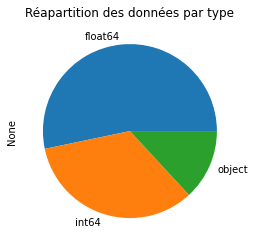

In [12]:
# connaitre les types de valeur de notre jeu de données avec un graph
app_train.dtypes.value_counts().plot.pie()
plt.title('Réapartition des données par type')
plt.savefig(chemin_graph+"Affichage arbre des catégories", dpi=400,bbox_inches='tight', pad_inches=0.5)

In [81]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

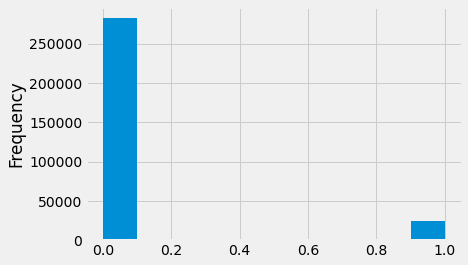

In [82]:
app_train['TARGET'].astype(int).plot.hist();

Données scoring avec 2 catégories avec 0 la probabilité des personnes qui remboursent leur crédit soit 282 686 et 1 non ceux qui ne réussissent pas à rembourser estimé à 24 825

## Analyse des données manquantes - dataframe de crédit <a class="anchor" id="section_2_3"></a>

#### Création d'un dataframe spécifique aux données manquantes => obtenir un graphique plus lisible car moins chargé <a class="anchor" id="section_2_4"></a>

In [7]:
#A exécuter
app_train_vide=pd.DataFrame()
for i in range(0,len(app_train.columns.values)):
    if (app_train.iloc[:,[i]].isna().sum(axis=0)>0).bool():
        app_train_vide.loc[:,app_train.columns.values[i]]= app_train.iloc[:,i]

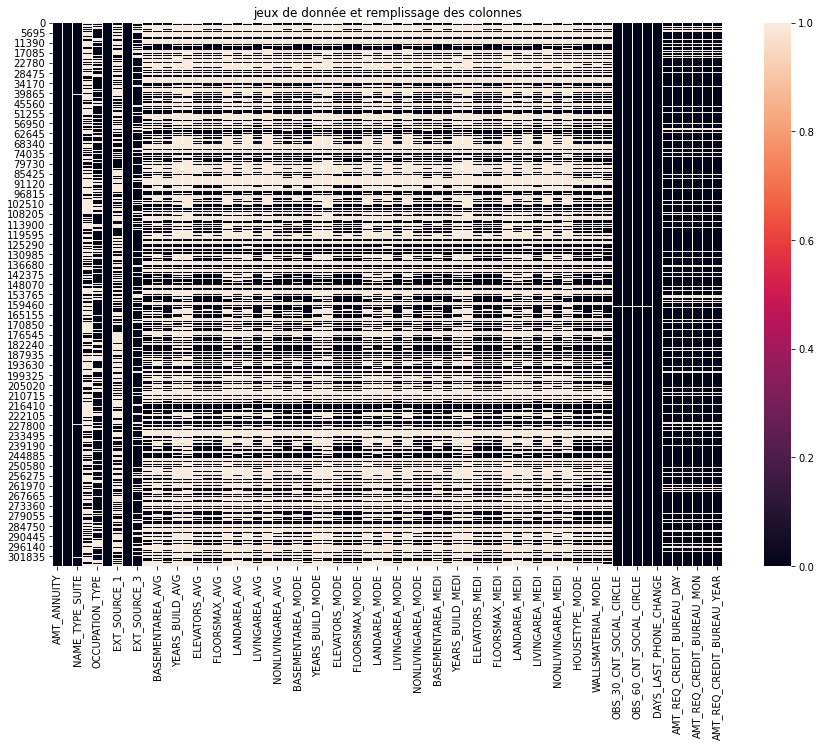

In [11]:
#A exécuter (optionnel une seconde fois)
plt.figure(figsize=(15,10))
plt.title('jeux de donnée et remplissage des colonnes')
sns.heatmap(app_train_vide.isnull())
# blanc valeurs manquantes on peut aussi voir des lignes qui peuveent être supp par la suite
plt.savefig(chemin_graph+"Affichage des valeurs manquantes état initial", dpi=400,bbox_inches='tight', pad_inches=0.5)

In [8]:
#A exécuter
# Fonction pour calculer les valeurs manquantes
def missing_values_table(df):
        # Total valeurs manquantes
        mis_val = df.isnull().sum()
        
        # Pourcentage valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Table des résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renommer les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs manquantes', 1 : 'Taux manquant'})
        
        # Trie
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'Taux manquant', ascending=False).round(1)
        
        # Synthése
        print ("Le jeu de données total a  " + str(app_train.shape[1]) + " columns.\n"      
            "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes comportant des valeurs nulles.")
        
        # Retourne et affichage des résultats
        return mis_val_table_ren_columns


In [9]:
#A exécuter
# Taux des valeurs manquantes
missing_values = missing_values_table(app_train_vide)
#missing_values.head(20)

Le jeu de données total a  122 columns.
Il y a 67 colonnes comportant des valeurs nulles.


In [242]:
#print("Valeurs manquantes ")
#print(app_train_vide.isna().sum().sort_values(ascending=False),(app_train_vide.isna().sum()/app_train.shape[0]).sort_values(ascending=False)) 

In [243]:
#A exécuter optionnel
#(app_train.isna().sum()/app_train.shape[0]).sort_values(ascending=False)
#app_train_vide
(app_train_vide.isna().sum()/app_train.shape[0]).sort_values(ascending=False)

COMMONAREA_MEDI                 0.698723
COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
NONLIVINGAPARTMENTS_MEDI        0.694330
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_MEDI           0.683550
LIVINGAPARTMENTS_AVG            0.683550
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
FLOORSMIN_AVG                   0.678486
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_AVG                 0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_AVG                    0.593767
LANDAREA_MEDI                   0.593767
LANDAREA_MODE                   0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_ME

In [13]:
app_train_vide.isna().sum().sort_values(ascending=False)

COMMONAREA_MEDI                 214865
COMMONAREA_AVG                  214865
COMMONAREA_MODE                 214865
NONLIVINGAPARTMENTS_MEDI        213514
NONLIVINGAPARTMENTS_MODE        213514
NONLIVINGAPARTMENTS_AVG         213514
FONDKAPREMONT_MODE              210295
LIVINGAPARTMENTS_MODE           210199
LIVINGAPARTMENTS_MEDI           210199
LIVINGAPARTMENTS_AVG            210199
FLOORSMIN_MODE                  208642
FLOORSMIN_MEDI                  208642
FLOORSMIN_AVG                   208642
YEARS_BUILD_MODE                204488
YEARS_BUILD_MEDI                204488
YEARS_BUILD_AVG                 204488
OWN_CAR_AGE                     202929
LANDAREA_AVG                    182590
LANDAREA_MEDI                   182590
LANDAREA_MODE                   182590
BASEMENTAREA_MEDI               179943
BASEMENTAREA_AVG                179943
BASEMENTAREA_MODE               179943
EXT_SOURCE_1                    173378
NONLIVINGAREA_MEDI              169682
NONLIVINGAREA_MODE       

### Conclusion sur les données manquantes
* Beaucoup de données manquantes concernent les données liées à l'habitation au sens large. Ces données seraient-elles moins importantes pour l'obtention d'une crédit à la consommation.
* Parti pris de ne pas traiter ces variables mais à confirmer avec analyse corrélation

## Analyse des colonnes 'object' <a class="anchor" id="section_2_5"></a>

In [10]:
# A exécuter
lst_var_obj=[]
# Nombre de colonne avec des objects
index_apptrain_objet=app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0).index
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [11]:
for i in index_apptrain_objet:
    lst_var_obj.append(i)
#print(lst_var_obj)

### Les descriptions des colonnes 'object' - extrait du dataframe "description_files" <a class="anchor" id="section_2_6"></a>

In [74]:
#df_description=pd.DataFrame(columns=[])

In [12]:
#A exécuter car utile d'avoir cette information pour la suite de l'analyse, meilleure compréhension des données
for i in lst_var_obj:
    print(i,description_files[description_files['Table']=='application_{train|test}.csv'][description_files['Row']==i]['Description'].values)

NAME_CONTRACT_TYPE ['Identification if loan is cash or revolving']
CODE_GENDER ['Gender of the client']
FLAG_OWN_CAR ['Flag if the client owns a car']
FLAG_OWN_REALTY ['Flag if client owns a house or flat']
NAME_TYPE_SUITE ['Who was accompanying client when he was applying for the loan']
NAME_INCOME_TYPE ['Clients income type (businessman, working, maternity leave,�)']
NAME_EDUCATION_TYPE ['Level of highest education the client achieved']
NAME_FAMILY_STATUS ['Family status of the client']
NAME_HOUSING_TYPE ['What is the housing situation of the client (renting, living with parents, ...)']
OCCUPATION_TYPE ['What kind of occupation does the client have']
WEEKDAY_APPR_PROCESS_START ['On which day of the week did the client apply for the loan']
ORGANIZATION_TYPE ['Type of organization where client works']
FONDKAPREMONT_MODE ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, 

#  Analyse univariée et multivariée <a class="anchor" id="chapter3"></a>

In [231]:
#séparation des données par type pour manipuler en groupe
#for col in app_train.select_dtypes('object'):
#    plt.figure(figsize=(15,10))
#    app_train[col].value_counts().plot.pie()

## Statistique sur  les colonnes object <a class="anchor" id="section_3_1"></a>

In [13]:
#A exécuter pour le graph ci-dessous
categorical_cols = app_train.select_dtypes(include=["object"]).columns.tolist()

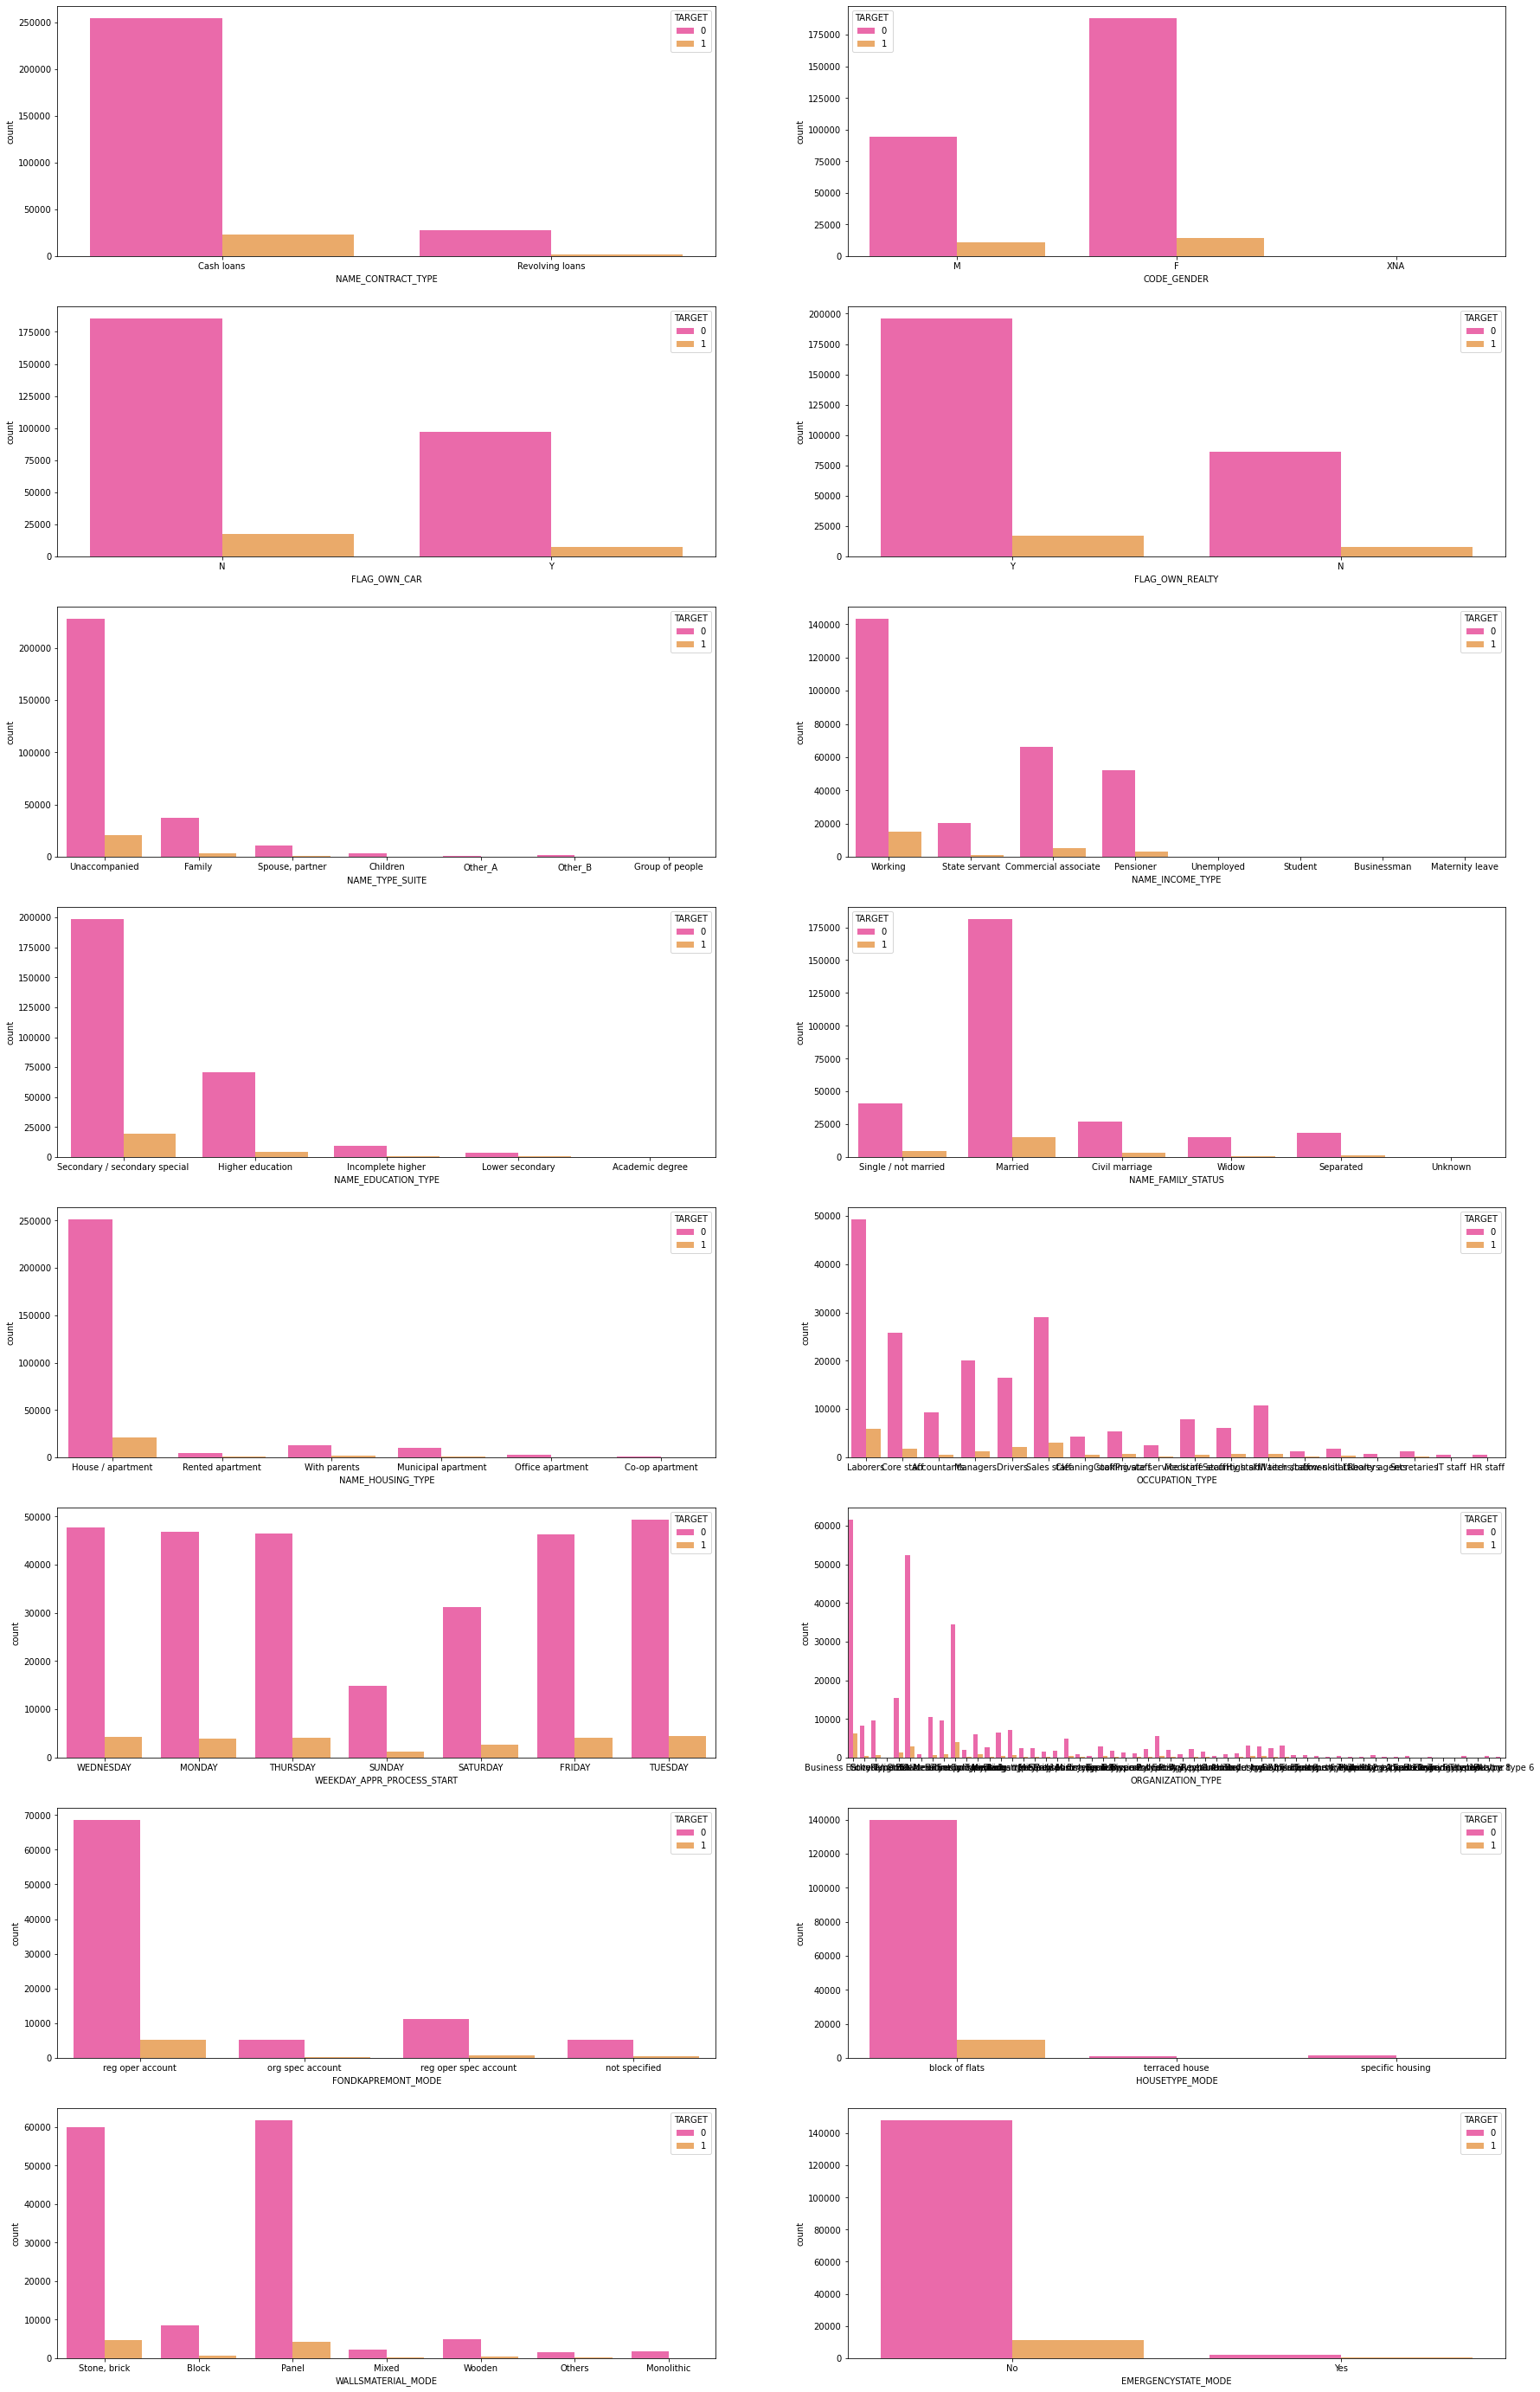

In [18]:
#A exécuter (optionnel une seconde fois)
fig , axs = plt.subplots(ncols=2,nrows=8,figsize=(30,50))
index=0
axs = axs.flatten()
for cols in categorical_cols:
        g = sns.countplot(x=cols,hue='TARGET',data=app_train,ax=axs[index],palette="spring")   
        index +=1
#plt.savefig(chemin_graph+"Affichage des valeurs manquantes état initial", dpi=400,bbox_inches='tight', pad_inches=0.5)        

## Statistique sur les données numériques <a class="anchor" id="section_3_2"></a>

### Affichages des libellés descriptions des rubriques numériques <a class="anchor" id="section_3_3"></a>

In [14]:
#A exécuter car utile d'avoir cette information pour la suite de l'analyse, meilleure compréhension des données
lst_var_num=[]
dic_num={}
# Nombre de colonne avec des objects
index_apptrain_num=app_train.select_dtypes(['float64','int64']).apply(pd.Series.nunique, axis = 0).index
#app_train.select_dtypes('float64','int64').apply(pd.Series.nunique, axis = 0)
#print(index_apptrain_num)
for i in index_apptrain_num:
    lst_var_num.append(i)
#print(lst_var_obj)
for i in lst_var_num:
    print(i,description_files[description_files['Table']=='application_{train|test}.csv'][description_files['Row']==i]['Description'].values)
    dic_num.update({i:str(description_files[description_files['Table']=='application_{train|test}.csv'][description_files['Row']==i]['Description'].values[0])})

SK_ID_CURR ['ID of loan in our sample']
TARGET ['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']
CNT_CHILDREN ['Number of children the client has']
AMT_INCOME_TOTAL ['Income of the client']
AMT_CREDIT ['Credit amount of the loan']
AMT_ANNUITY ['Loan annuity']
AMT_GOODS_PRICE ['For consumer loans it is the price of the goods for which the loan is given']
REGION_POPULATION_RELATIVE ['Normalized population of region where client lives (higher number means the client lives in more populated region)']
DAYS_BIRTH ["Client's age in days at the time of application"]
DAYS_EMPLOYED ['How many days before the application the person started current employment']
DAYS_REGISTRATION ['How many days before the application did client change his registration']
DAYS_ID_PUBLISH ['How many days before the application did client change the identity document with which 

LIVINGAREA_MODE ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']
NONLIVINGAPARTMENTS_MODE ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']
NONLIVINGAREA_MODE ['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']
APARTMENTS_MEDI ['Normalized information about building where the client lives, What is average (

In [92]:
#print(type(dic_num))
#print(len(dic_num))

In [15]:
#A exécuter pour la suite du traitement
lst_building=[]
for i in dic_num:
    #print(dic_num.keys(),dic_num.items())
    #print(type(dic_num.items()))
    #print(type(dic_num[i]))
    if dic_num[i].find('building')>0:
           lst_building.append(i)     

In [17]:
print("Nombre de variables avec pour référence Building ", len(lst_building))
#print(type(lst_building))
#print(lst_building)

Nombre de variables avec pour référence Building  43


## Affichage courbe densité des données numériques <a class="anchor" id="section_3_4"></a>

Rappel : Nous avons un dataset de 307 511 lignes
AMT_INCOME_TOTAL
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_INCOME_TOTAL


<Figure size 720x144 with 0 Axes>

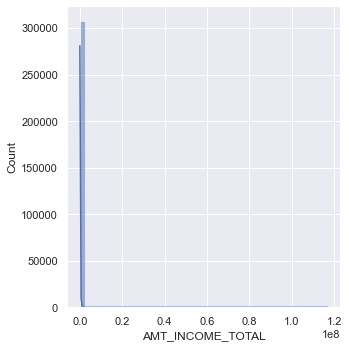

AMT_CREDIT
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_CREDIT


<Figure size 720x144 with 0 Axes>

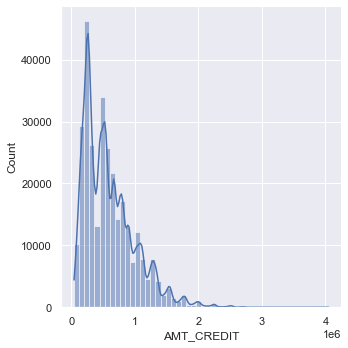

AMT_ANNUITY
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_ANNUITY


<Figure size 720x144 with 0 Axes>

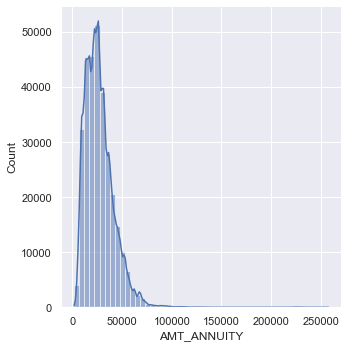

AMT_GOODS_PRICE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_GOODS_PRICE


<Figure size 720x144 with 0 Axes>

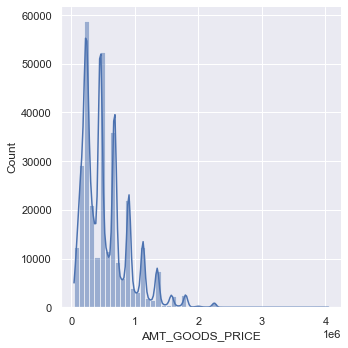

REGION_POPULATION_RELATIVE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques REGION_POPULATION_RELATIVE


<Figure size 720x144 with 0 Axes>

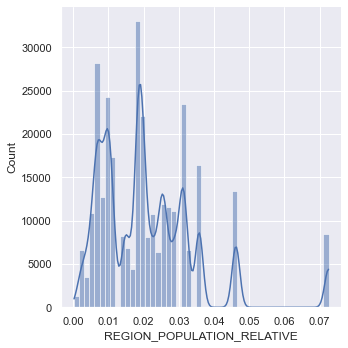

DAYS_EMPLOYED
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques DAYS_EMPLOYED


<Figure size 720x144 with 0 Axes>

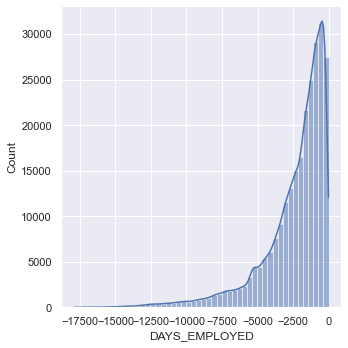

DAYS_REGISTRATION
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques DAYS_REGISTRATION


<Figure size 720x144 with 0 Axes>

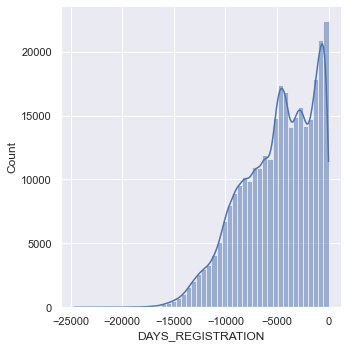

OWN_CAR_AGE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques OWN_CAR_AGE


<Figure size 720x144 with 0 Axes>

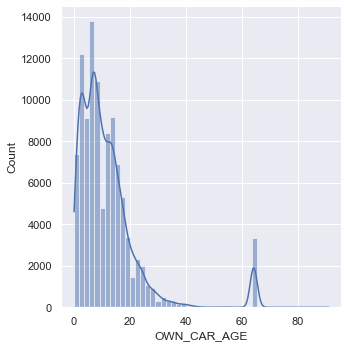

CNT_FAM_MEMBERS
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques CNT_FAM_MEMBERS


<Figure size 720x144 with 0 Axes>

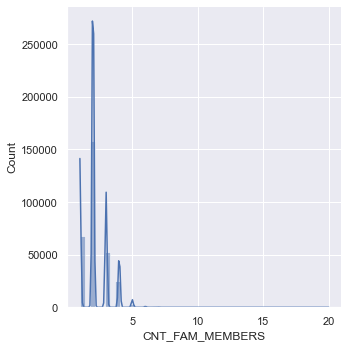

EXT_SOURCE_1
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques EXT_SOURCE_1


<Figure size 720x144 with 0 Axes>

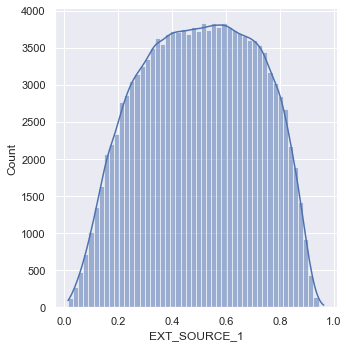

EXT_SOURCE_2
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques EXT_SOURCE_2


<Figure size 720x144 with 0 Axes>

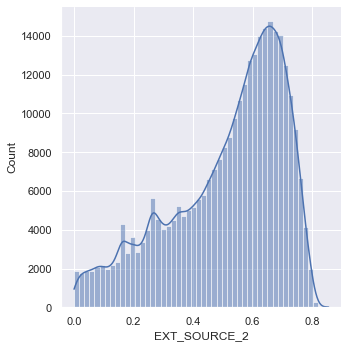

EXT_SOURCE_3
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques EXT_SOURCE_3


<Figure size 720x144 with 0 Axes>

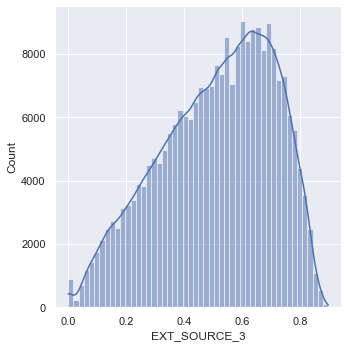

APARTMENTS_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques APARTMENTS_AVG


<Figure size 720x144 with 0 Axes>

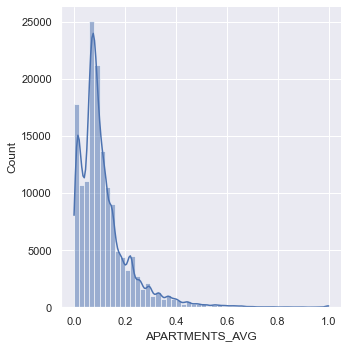

BASEMENTAREA_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques BASEMENTAREA_AVG


<Figure size 720x144 with 0 Axes>

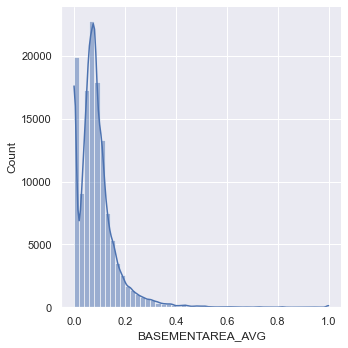

YEARS_BEGINEXPLUATATION_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques YEARS_BEGINEXPLUATATION_AVG


<Figure size 720x144 with 0 Axes>

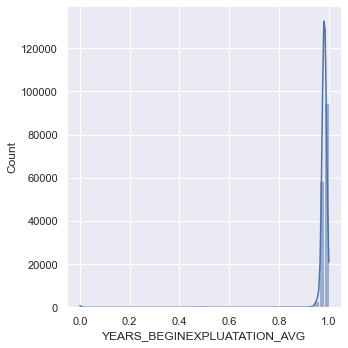

YEARS_BUILD_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques YEARS_BUILD_AVG


<Figure size 720x144 with 0 Axes>

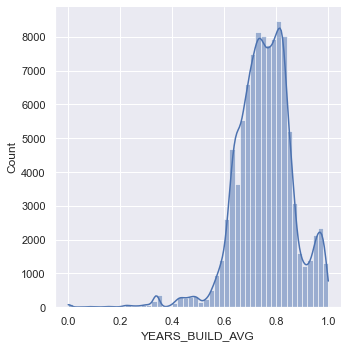

COMMONAREA_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques COMMONAREA_AVG


<Figure size 720x144 with 0 Axes>

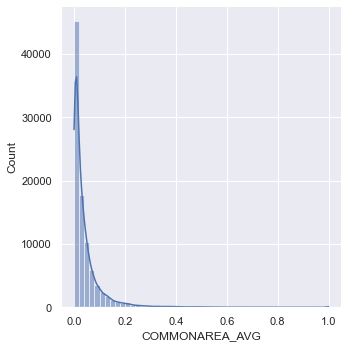

ELEVATORS_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques ELEVATORS_AVG


<Figure size 720x144 with 0 Axes>

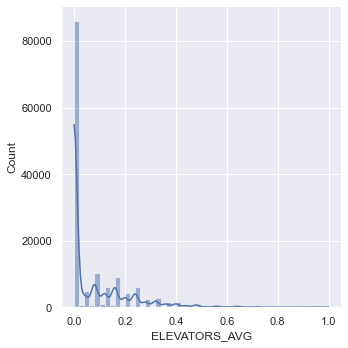

ENTRANCES_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques ENTRANCES_AVG


<Figure size 720x144 with 0 Axes>

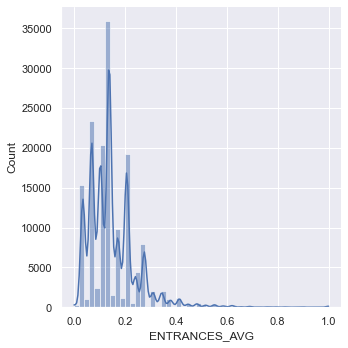

FLOORSMAX_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques FLOORSMAX_AVG


<Figure size 720x144 with 0 Axes>

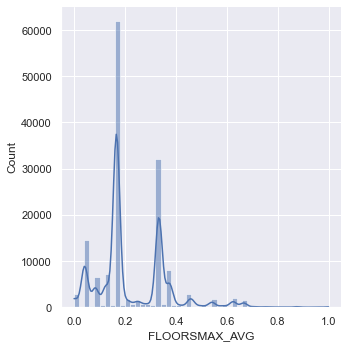

FLOORSMIN_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques FLOORSMIN_AVG


<Figure size 720x144 with 0 Axes>

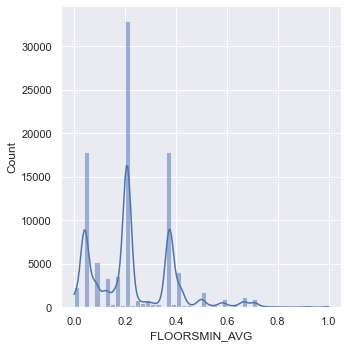

LANDAREA_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LANDAREA_AVG


<Figure size 720x144 with 0 Axes>

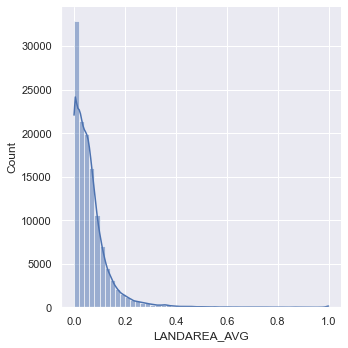

LIVINGAPARTMENTS_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LIVINGAPARTMENTS_AVG


<Figure size 720x144 with 0 Axes>

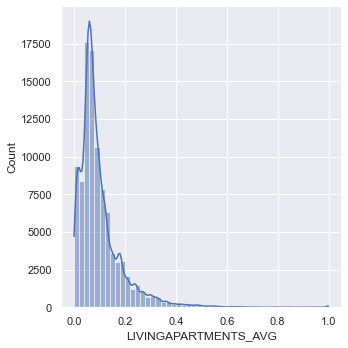

LIVINGAREA_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LIVINGAREA_AVG


<Figure size 720x144 with 0 Axes>

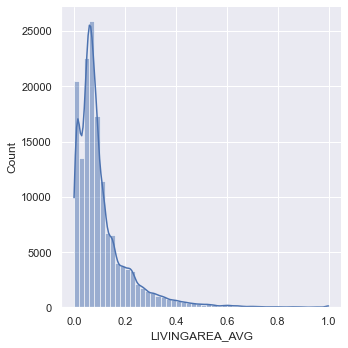

NONLIVINGAPARTMENTS_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques NONLIVINGAPARTMENTS_AVG


<Figure size 720x144 with 0 Axes>

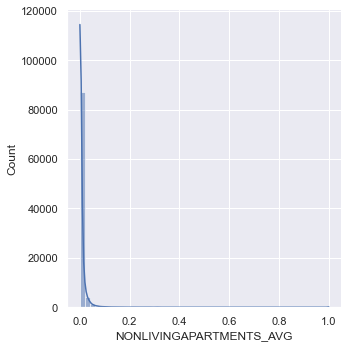

NONLIVINGAREA_AVG
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques NONLIVINGAREA_AVG


<Figure size 720x144 with 0 Axes>

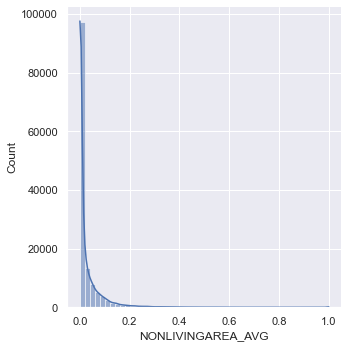

APARTMENTS_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques APARTMENTS_MODE


<Figure size 720x144 with 0 Axes>

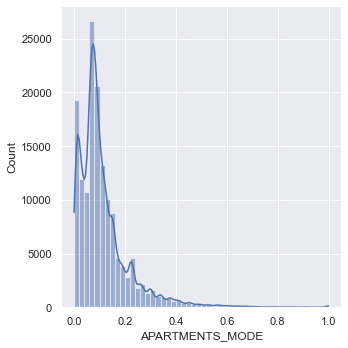

BASEMENTAREA_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques BASEMENTAREA_MODE


<Figure size 720x144 with 0 Axes>

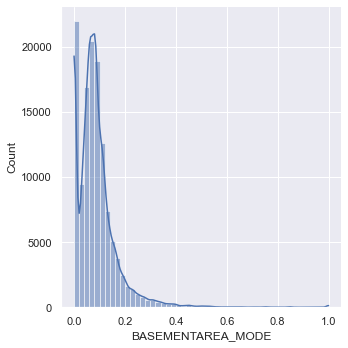

YEARS_BEGINEXPLUATATION_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques YEARS_BEGINEXPLUATATION_MODE


<Figure size 720x144 with 0 Axes>

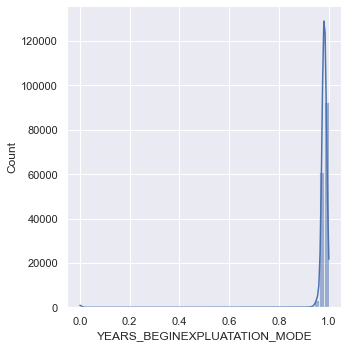

YEARS_BUILD_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques YEARS_BUILD_MODE


<Figure size 720x144 with 0 Axes>

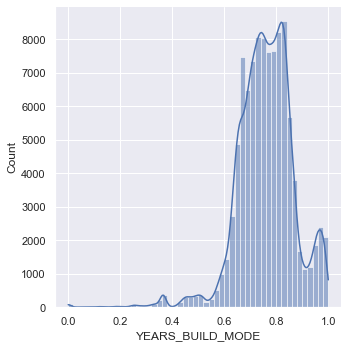

COMMONAREA_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques COMMONAREA_MODE


<Figure size 720x144 with 0 Axes>

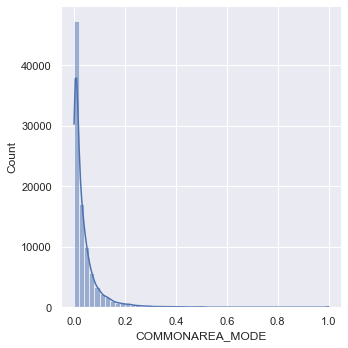

ELEVATORS_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques ELEVATORS_MODE


<Figure size 720x144 with 0 Axes>

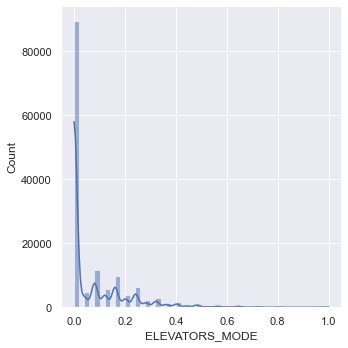

ENTRANCES_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques ENTRANCES_MODE


<Figure size 720x144 with 0 Axes>

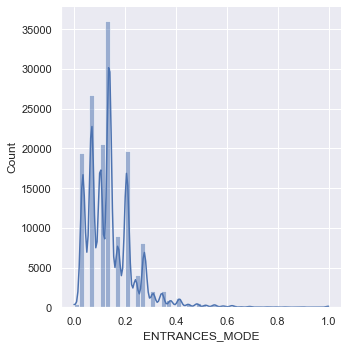

FLOORSMAX_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques FLOORSMAX_MODE


<Figure size 720x144 with 0 Axes>

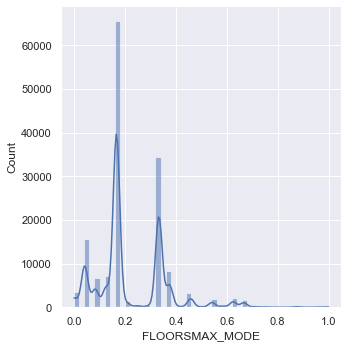

FLOORSMIN_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques FLOORSMIN_MODE


<Figure size 720x144 with 0 Axes>

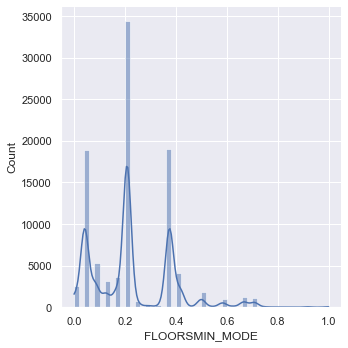

LANDAREA_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LANDAREA_MODE


<Figure size 720x144 with 0 Axes>

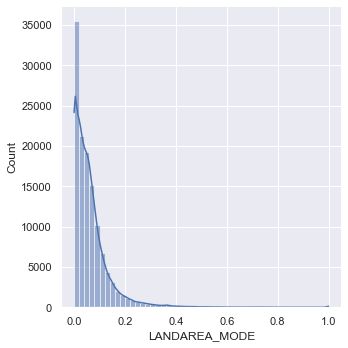

LIVINGAPARTMENTS_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LIVINGAPARTMENTS_MODE


<Figure size 720x144 with 0 Axes>

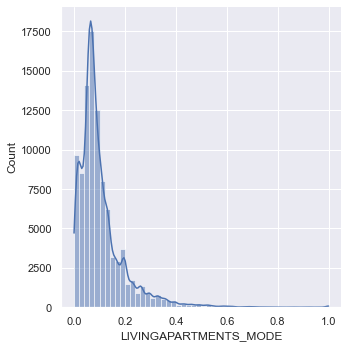

LIVINGAREA_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LIVINGAREA_MODE


<Figure size 720x144 with 0 Axes>

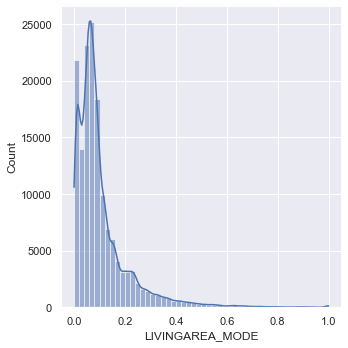

NONLIVINGAPARTMENTS_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques NONLIVINGAPARTMENTS_MODE


<Figure size 720x144 with 0 Axes>

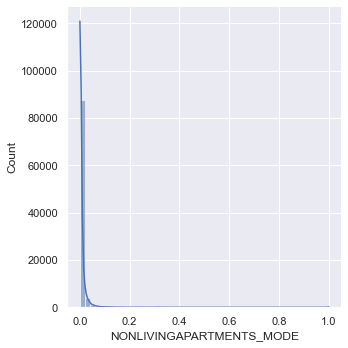

NONLIVINGAREA_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques NONLIVINGAREA_MODE


<Figure size 720x144 with 0 Axes>

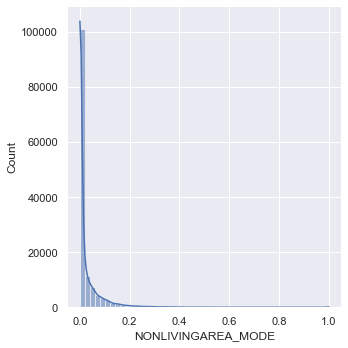

APARTMENTS_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques APARTMENTS_MEDI


<Figure size 720x144 with 0 Axes>

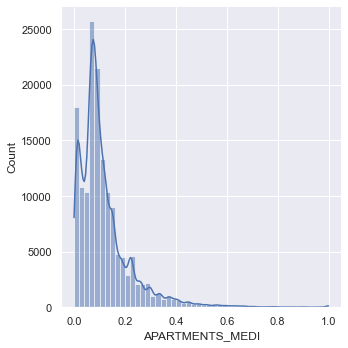

BASEMENTAREA_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques BASEMENTAREA_MEDI


<Figure size 720x144 with 0 Axes>

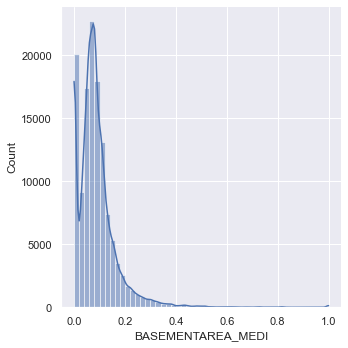

YEARS_BEGINEXPLUATATION_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques YEARS_BEGINEXPLUATATION_MEDI


<Figure size 720x144 with 0 Axes>

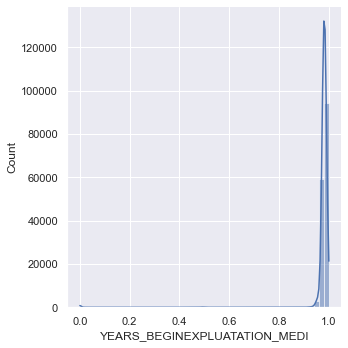

YEARS_BUILD_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques YEARS_BUILD_MEDI


<Figure size 720x144 with 0 Axes>

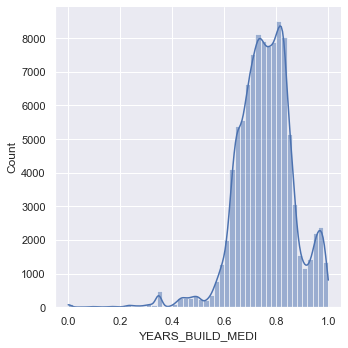

COMMONAREA_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques COMMONAREA_MEDI


<Figure size 720x144 with 0 Axes>

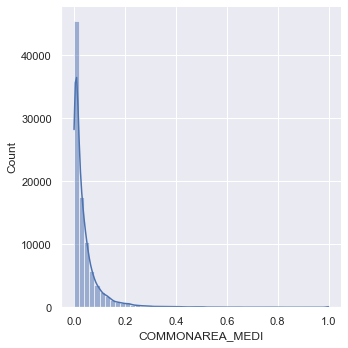

ELEVATORS_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques ELEVATORS_MEDI


<Figure size 720x144 with 0 Axes>

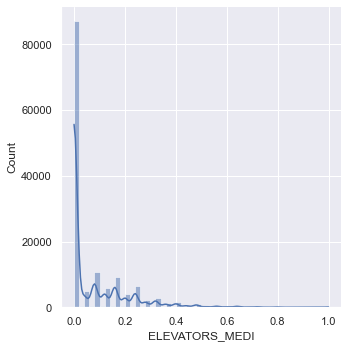

ENTRANCES_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques ENTRANCES_MEDI


<Figure size 720x144 with 0 Axes>

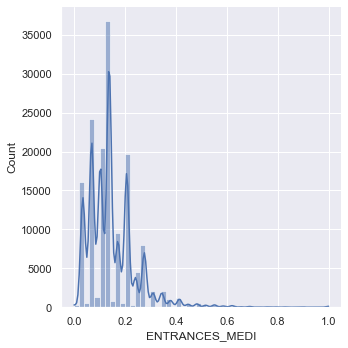

FLOORSMAX_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques FLOORSMAX_MEDI


<Figure size 720x144 with 0 Axes>

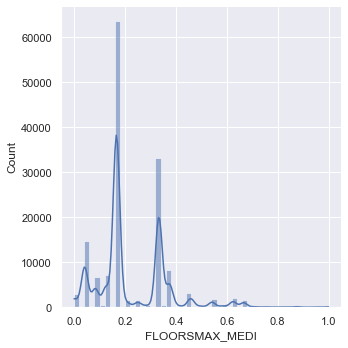

FLOORSMIN_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques FLOORSMIN_MEDI


<Figure size 720x144 with 0 Axes>

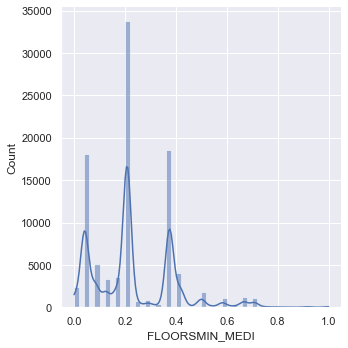

LANDAREA_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LANDAREA_MEDI


<Figure size 720x144 with 0 Axes>

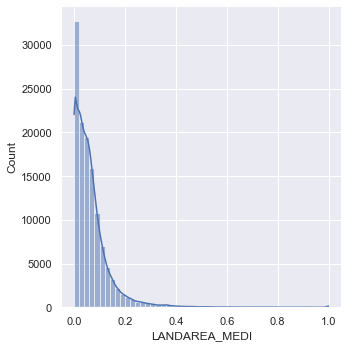

LIVINGAPARTMENTS_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LIVINGAPARTMENTS_MEDI


<Figure size 720x144 with 0 Axes>

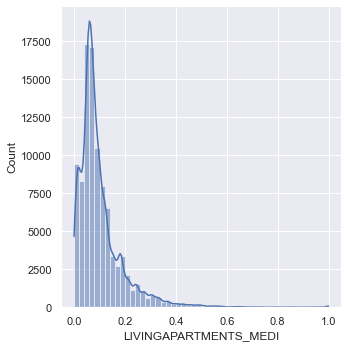

LIVINGAREA_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques LIVINGAREA_MEDI


<Figure size 720x144 with 0 Axes>

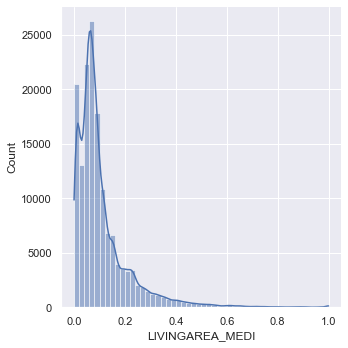

NONLIVINGAPARTMENTS_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques NONLIVINGAPARTMENTS_MEDI


<Figure size 720x144 with 0 Axes>

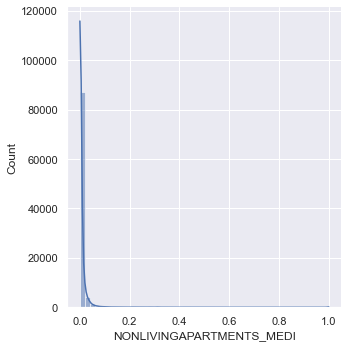

NONLIVINGAREA_MEDI
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques NONLIVINGAREA_MEDI


<Figure size 720x144 with 0 Axes>

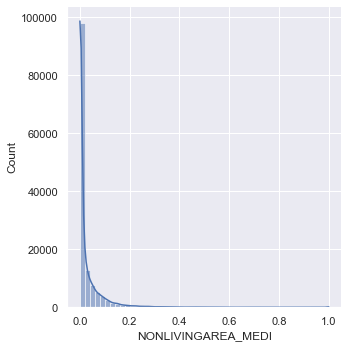

TOTALAREA_MODE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques TOTALAREA_MODE


<Figure size 720x144 with 0 Axes>

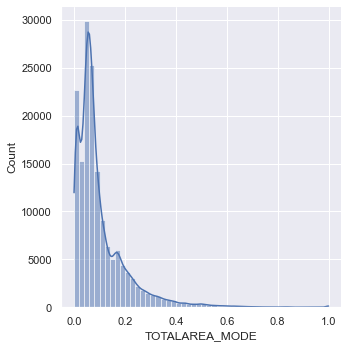

OBS_30_CNT_SOCIAL_CIRCLE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques OBS_30_CNT_SOCIAL_CIRCLE


<Figure size 720x144 with 0 Axes>

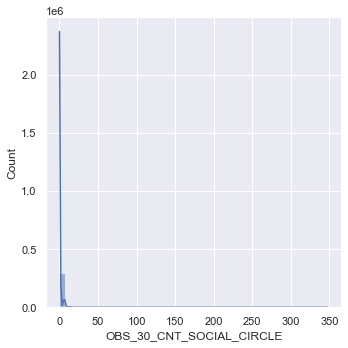

DEF_30_CNT_SOCIAL_CIRCLE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques DEF_30_CNT_SOCIAL_CIRCLE


<Figure size 720x144 with 0 Axes>

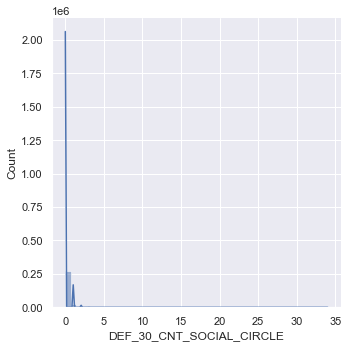

OBS_60_CNT_SOCIAL_CIRCLE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques OBS_60_CNT_SOCIAL_CIRCLE


<Figure size 720x144 with 0 Axes>

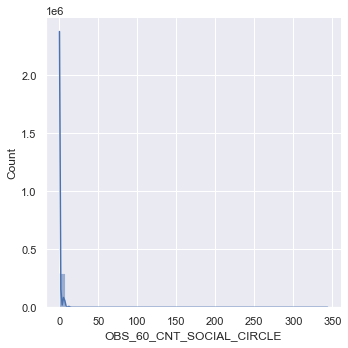

DEF_60_CNT_SOCIAL_CIRCLE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques DEF_60_CNT_SOCIAL_CIRCLE


<Figure size 720x144 with 0 Axes>

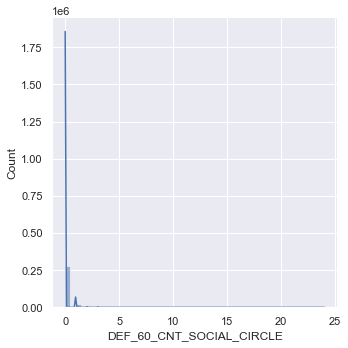

DAYS_LAST_PHONE_CHANGE
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques DAYS_LAST_PHONE_CHANGE


<Figure size 720x144 with 0 Axes>

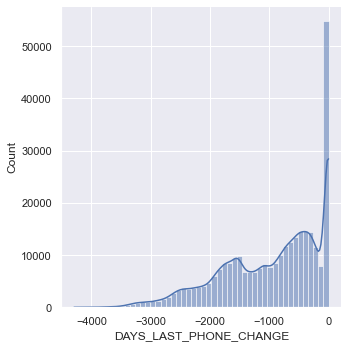

AMT_REQ_CREDIT_BUREAU_HOUR
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_REQ_CREDIT_BUREAU_HOUR


<Figure size 720x144 with 0 Axes>

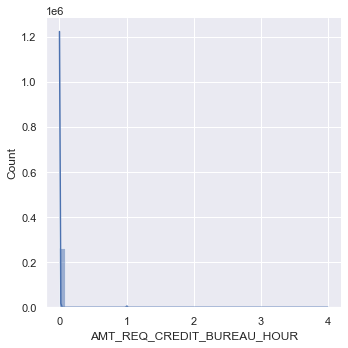

AMT_REQ_CREDIT_BUREAU_DAY
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_REQ_CREDIT_BUREAU_DAY


<Figure size 720x144 with 0 Axes>

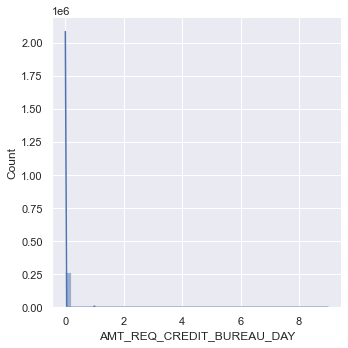

AMT_REQ_CREDIT_BUREAU_WEEK
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_REQ_CREDIT_BUREAU_WEEK


<Figure size 720x144 with 0 Axes>

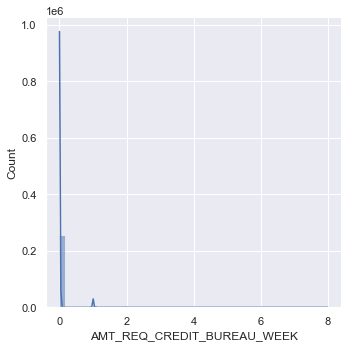

AMT_REQ_CREDIT_BUREAU_MON
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_REQ_CREDIT_BUREAU_MON


<Figure size 720x144 with 0 Axes>

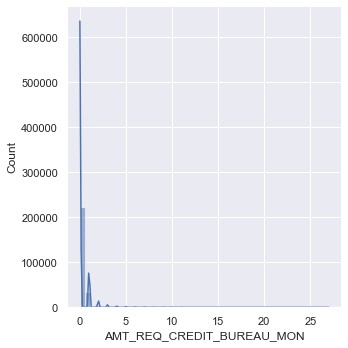

AMT_REQ_CREDIT_BUREAU_QRT
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_REQ_CREDIT_BUREAU_QRT


<Figure size 720x144 with 0 Axes>

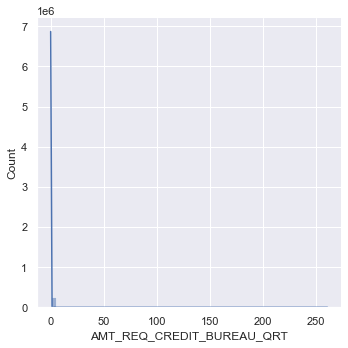

AMT_REQ_CREDIT_BUREAU_YEAR
C:/Users/User/Documents/OpenClassroom/Projet7/P7_mercier_jeanraoul/Graph/Affichage courbes de densité variables numériques AMT_REQ_CREDIT_BUREAU_YEAR


<Figure size 720x144 with 0 Axes>

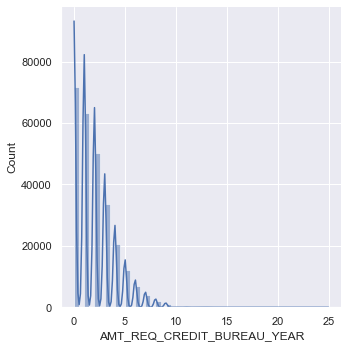

In [245]:
# 2ème exécution optionnelle
print('Rappel : Nous avons un dataset de 307 511 lignes')
#séparation des données par type pour manipuler en groupe
for col in app_train.select_dtypes('float64','int64'):
    print(col)
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.displot(app_train[col], bins=50, kde=True) # rajoute kde=True pour avoir la courbe
    titre_fig="Affichage courbes de densité variables numériques "+col
    print(chemin_graph+titre_fig)    
    plt.savefig(chemin_graph+titre_fig, dpi=400,bbox_inches='tight', pad_inches=0.5) 
    plt.show()
#plt.savefig(chemin_graph+"Affichage courbes de densité variables numériques", dpi=400,bbox_inches='tight', pad_inches=0.5)    

In [36]:
app_train[['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_GOODS_PRICE']].describe()

AMT_INCOME_TOTAL    AMT_CREDIT  AMT_GOODS_PRICE
count      3.075110e+05  3.075110e+05     3.072330e+05
mean       1.687979e+05  5.990260e+05     5.383962e+05
std        2.371231e+05  4.024908e+05     3.694465e+05
min        2.565000e+04  4.500000e+04     4.050000e+04
25%        1.125000e+05  2.700000e+05     2.385000e+05
50%        1.471500e+05  5.135310e+05     4.500000e+05
75%        2.025000e+05  8.086500e+05     6.795000e+05
max        1.170000e+08  4.050000e+06     4.050000e+06

# <font  color='blue' > Transformation des dataframes pour la modélisation </font> <a class="anchor" id="chapter4"></a>

#### Sauvegarde 2
* app_train
* app_test

In [16]:
app_train_sv=app_train.copy()
app_test_sv=app_test.copy() 

##### Restauration pour mise au point

In [48]:
app_train=app_train_sv.copy()
app_test=app_test_sv.copy()

## Encodage de nos données features "Object" </font> <a class="anchor" id="section_4_1"></a>

In [17]:
# A exécuter pour constitution des jeu de données pour modélisation
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            print("Colonnes encodées ",col)
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d sont encodés.' % le_count)

Colonnes encodées  NAME_CONTRACT_TYPE
Colonnes encodées  FLAG_OWN_CAR
Colonnes encodées  FLAG_OWN_REALTY
3 sont encodés.


In [76]:
#app_train

## get dummies et encodage à un coup </font> <a class="anchor" id="section_4_2"></a>

In [18]:
#A exécuter
print('Taille de nos données train features avt trait dummies: ', app_train.shape)
print('Taille de nos données test features avt trait dummies:', app_test.shape)
#one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Taille de nos données train features ap traitement: ', app_train.shape)
print('Taille de nos données test features ap traitement: ', app_test.shape)

Taille de nos données train features avt trait dummies:  (307511, 122)
Taille de nos données test features avt trait dummies: (48744, 121)
Taille de nos données train features ap traitement:  (307511, 243)
Taille de nos données test features ap traitement:  (48744, 239)


In [135]:
app_train

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1                   0             0                1   
1           100003       0                   0             0                0   
2           100004       0                   1             1                1   
3           100006       0                   0             0                1   
4           100007       0                   0             0                1   
...            ...     ...                 ...           ...              ...   
307506      456251       0                   0             0                0   
307507      456252       0                   0             0                1   
307508      456253       0                   0             0                1   
307509      456254       1                   0             0                1   
307510      456255       0                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801       -9461   
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561       -9327   
307507         225000.0                    0.025164      -20775   
307508         585000.0                    0.005002      -14966   
307509         319500.0                    0.005313      -11961   
307510         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                -637            -3648.0            -2120          NaN   
1               -1188            -1186.0             -291          NaN   
2                -225            -4260.0            -2531         26.0   
3               -3039            -9833.0            -2437          NaN   
4               -3038            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506           -236            -8456.0            -1982          NaN   
307507         365243            -4388.0            -4090          NaN   
307508          -7921            -6737.0            -5150          NaN   
307509          -4786            -2562.0             -931          NaN   
307510          -1262            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1       

### Mise en cohérence des dataframes app_train et app_test après "get_dummies" <a class="anchor" id="section_4_3"></a>
* Point important l'initialisation de train_labels avec TARGET

In [19]:
# A exécuter
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## Travail sur les périodes importantes (durée en jours) <a class="anchor" id="section_4_4"></a>
* Les périodes sont en négatifs. Jour d'origine : jour de la demande - le nombre de jours écoulés de début de l'évènement mesuré 
DAYS_BIRTH ["Client's age in days at the time of application"]
DAYS_EMPLOYED ['How many days before the application the person started current employment']



DAYS_REGISTRATION ['How many days before the application did client change his registration']
DAYS_ID_PUBLISH ['How many days before the application did client change the identity document with which he applied for the loan']

#### Age en année <a class="anchor" id="section_4_4_1"></a>

In [85]:
#app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [22]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

#### Nombre de jours dans le dernier emploi <a class="anchor" id="section_4_4_2"></a>

In [116]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

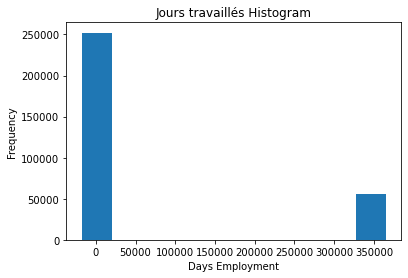

In [23]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Jours travaillés Histogram');
plt.xlabel('Days Employment');

In [20]:
#A exécuter
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('il y a %d anomalies en jour de travail' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
il y a 55374 anomalies en jour de travail


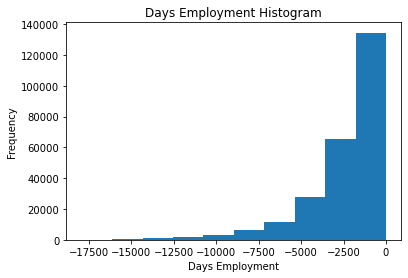

In [21]:
#A exécuter
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [22]:
# A exécuter
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('Il y a %d anomalies dans le dataset out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

Il y a 9274 anomalies dans le dataset out of 48744 entries


# Afficher graphique des corrélations <a class="anchor" id="section_4_5"></a>

In [1]:
# Find correlations with the target and sort
#correlations = app_train.corr()['TARGET'].sort_values()
#print(len(correlations))
# Display correlations
#print('Plus Positive Correlations:\n', correlations.tail(15))
#print('\n PlusNegative Correlations:\n', correlations.head(15))
#print(correlations)

In [26]:
correlations = app_train.corr()

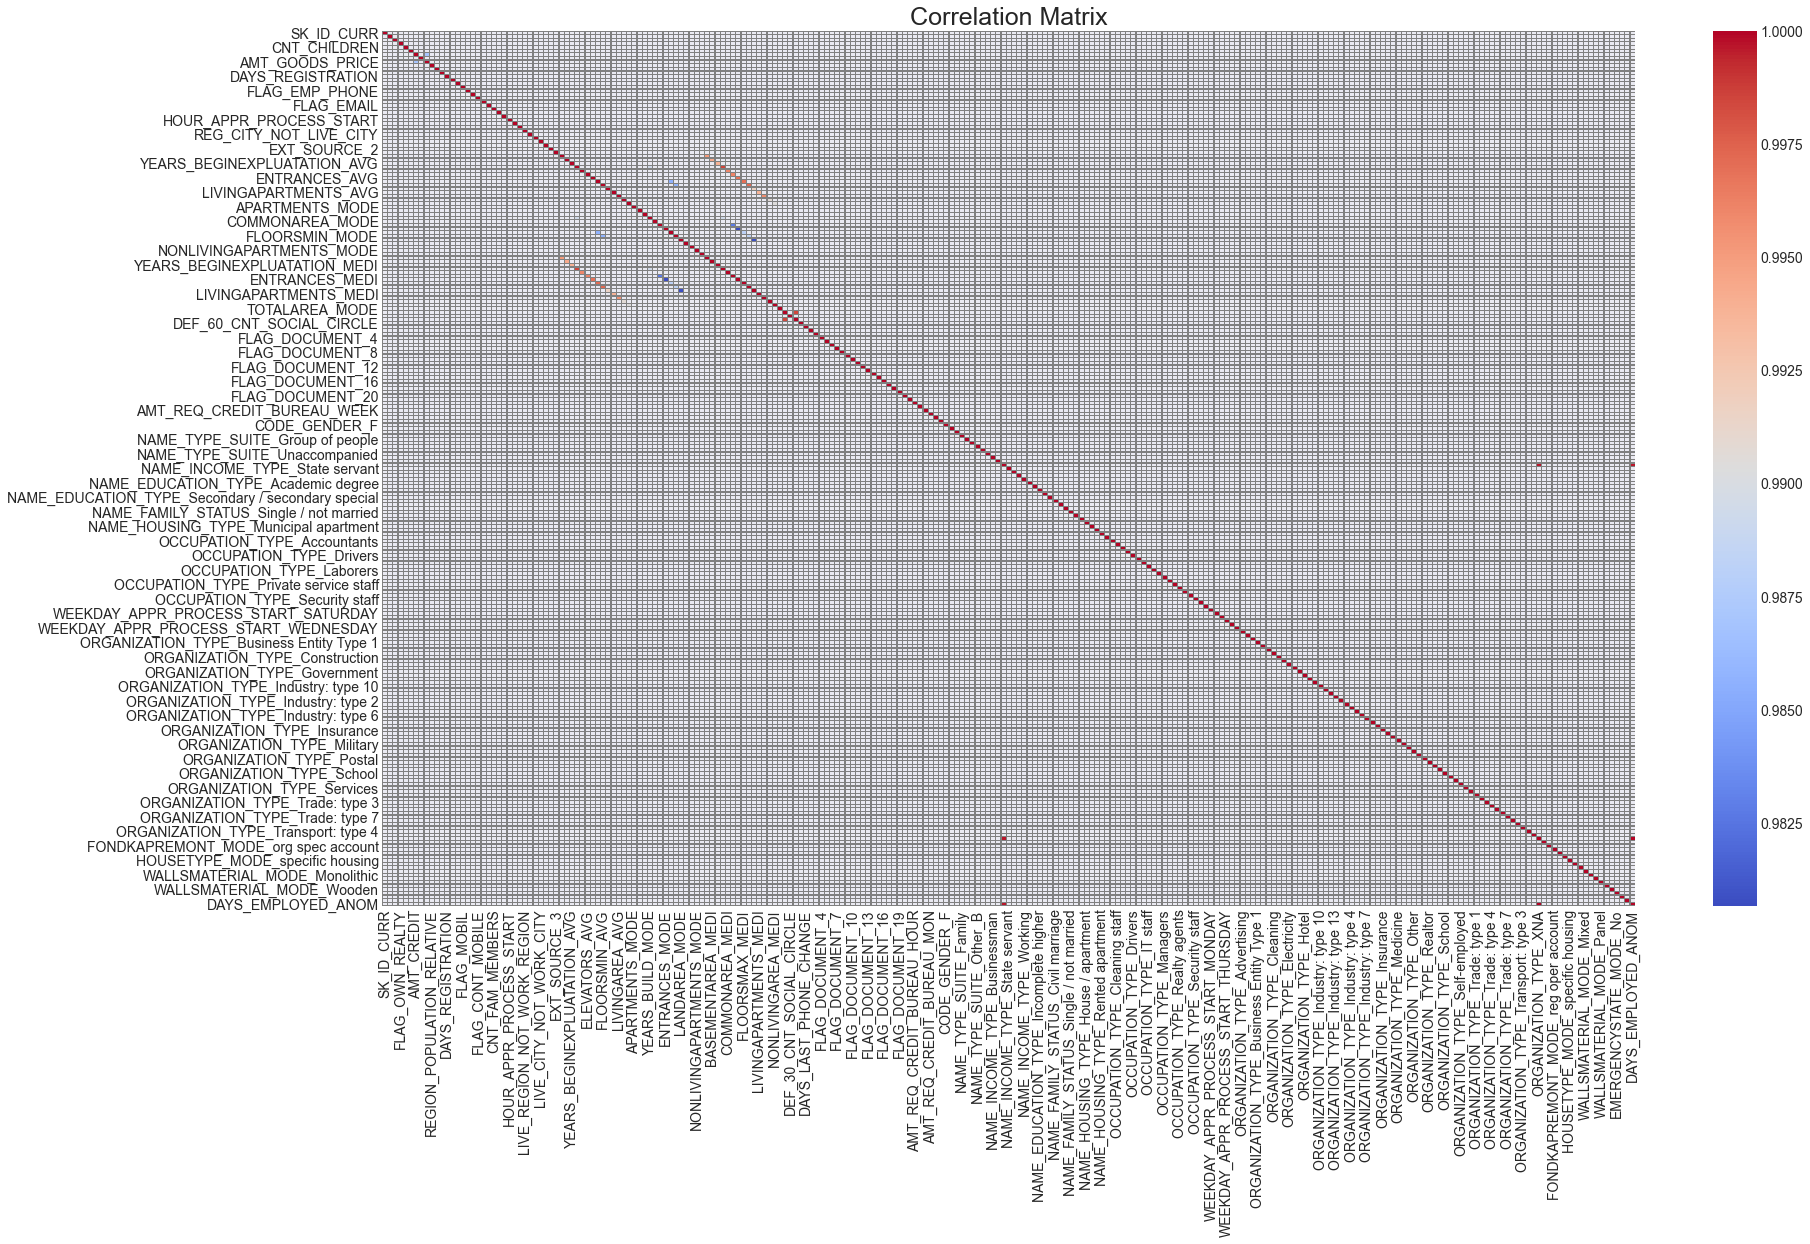

In [238]:
plt.figure(figsize=(25,15))
sns.heatmap(app_train.corr()[app_train.corr()>0.98], annot=False, cmap = 'coolwarm', linewidths=.2, linecolor='grey') # plus lisible
plt.title('Correlation Matrix', fontsize=25);
plt.savefig(chemin_graph+"Affichage de la matrice de corrélation", dpi=400,bbox_inches='tight', pad_inches=0.5) 

### Les corrélations les plus fortes concernent les données concernant les buildings dans le détail <a class="anchor" id="section_4_6"></a>
*** Nous ne retiendrons pas ces variables dans la suite de l'analyse

In [23]:
lst_building

['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE']

## Traitement des données manquantes avec suppression des colonnes liées aux "building" <a class="anchor" id="section_4_7"></a>

In [24]:
# A exécuter
 
app_train.drop(lst_building, axis=1, inplace=True)
app_test.drop(lst_building, axis=1, inplace=True)
print("Taille du df Train après suppression des colonnes Building :",app_train.shape)
print("Taille du df Test  après suppression des colonnes Building :",app_test.shape)

Taille du df Train après suppression des colonnes Building : (307511, 198)
Taille du df Test  après suppression des colonnes Building : (48744, 197)


## Zoom sur la rubrique AGE <a class="anchor" id="section_4_8"></a>

In [25]:
# A exécuter
# Trouver la corrélation des positives depuis les jours naissance
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982745

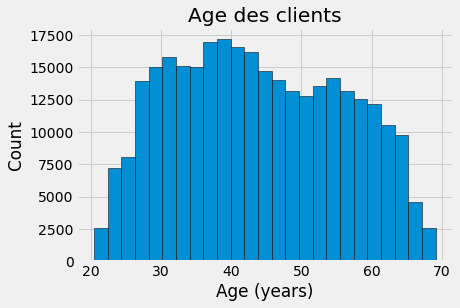

In [26]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age des clients'); plt.xlabel('Age (years)'); plt.ylabel('Count');
plt.savefig(chemin_graph+"Distribution des clients selon l'âge", dpi=400,bbox_inches='tight', pad_inches=0.5) 

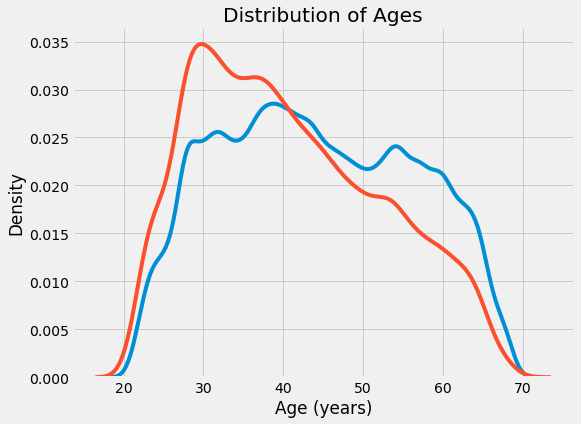

In [32]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.savefig(chemin_graph+"Distribution des clients selon l'âge en fonction de Target", dpi=400,bbox_inches='tight', pad_inches=0.5) 

In [26]:
# A exécuter (optionel seconde fois)
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [28]:
# A exécuter (optionel seconde fois)
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

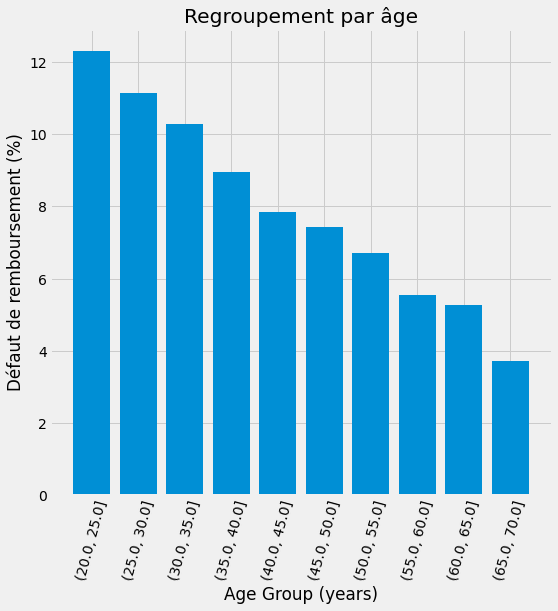

In [35]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Défaut de remboursement (%)')
plt.title('Regroupement par âge');
plt.savefig(chemin_graph+"Regrouprement des clients par âge", dpi=400,bbox_inches='tight', pad_inches=0.5) 

### Corrélation entre la cible, les notations extérieures et la naissance <a class="anchor" id="section_4_9"></a>
* EXT_SOURCE_* : 'Normalized score from external data source' 

In [29]:
# A exécuter (optionel seconde fois)
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

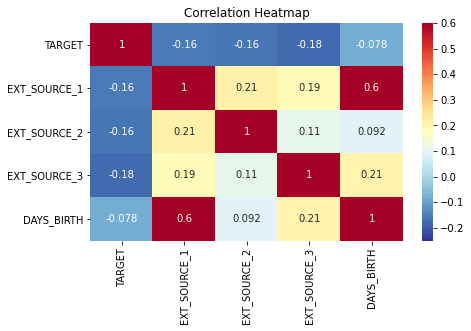

In [29]:
plt.figure(figsize = (7, 4))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');
plt.savefig(chemin_graph+"Correlation Target - Ext_Source, Days_bith", dpi=400,bbox_inches='tight', pad_inches=0.5)

### Graphique cible, les notations extérieures et la naissance <a class="anchor" id="section_4_10"></a>

Temps exécution pour graphique Ext Source and Age Features Pairs Plot :           213.67 secondes


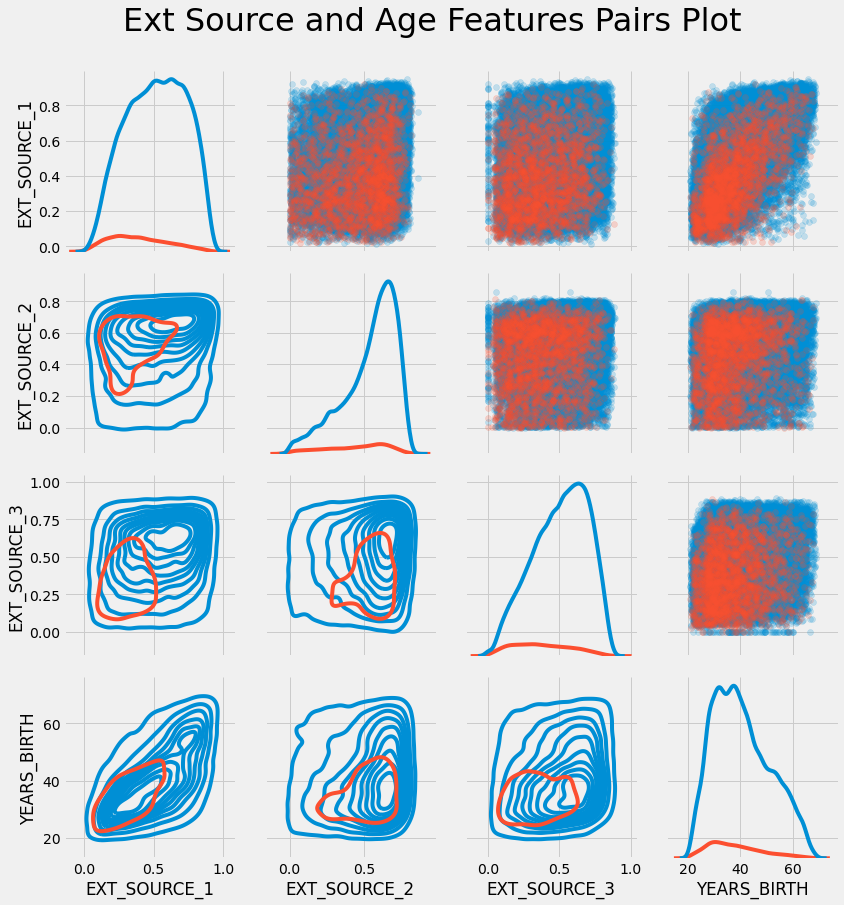

In [30]:
# A exécuter (optionnel une seconde fois)
temps0=time.time()
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

plt.savefig(chemin_graph+"Ext_Source and Age Features Pairs Plot", dpi=400,bbox_inches='tight', pad_inches=0.5)

duration0=time.time()-temps0
print("Temps exécution pour graphique Ext Source and Age Features Pairs Plot : ", "%15.2f" % duration0, "secondes")

In [32]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 198 columns):
 #    Column                                             Dtype  
---   ------                                             -----  
 0    SK_ID_CURR                                         int64  
 1    NAME_CONTRACT_TYPE                                 int32  
 2    FLAG_OWN_CAR                                       int32  
 3    FLAG_OWN_REALTY                                    int32  
 4    CNT_CHILDREN                                       int64  
 5    AMT_INCOME_TOTAL                                   float64
 6    AMT_CREDIT                                         float64
 7    AMT_ANNUITY                                        float64
 8    AMT_GOODS_PRICE                                    float64
 9    REGION_POPULATION_RELATIVE                         float64
 10   DAYS_BIRTH                                         int64  
 11   DAYS_EMPLOYED                        

# ==================================================================================

# <font  color='red' > Seconde partie - MODELISATION DU RISQUE METIER </font> <a class="anchor" id="chapter5"></a>

In [70]:
#A exécuter
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import gc
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve  

# Pour passer à l'étape préparation de jeu de données pour scoring 4 et 5
* [Création de 2 dataframes spécifique domain](#chapter9)

### Création du jeu de données avec données du dataframe 'training' <a class="anchor" id="section_5_1"></a>

#### Première normalisation des données du jeu d'essai avec traitement des valeurs manquantes

In [27]:
# A exécuter pour LA MODELISATION => Sans 'TARGET' et sans 'SK_ID_CURR'
# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

#SK_ID_CURR - identifiant client n'a pas à être modélisé

train=train.drop(columns = ['SK_ID_CURR'])
test=app_test.drop(columns = ['SK_ID_CURR'])

print(train.shape)
print(test.shape)

# Copy of the testing data
#test = app_test.copy()

# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)
print('Type train : ', type(train))
print('Type test : ', type(test))

#print("Date et heure d'exécution :",affiche_temps())

(307511, 196)
(48744, 196)
Training data shape:  (307511, 196)
Testing data shape:  (48744, 196)
Type train :  <class 'numpy.ndarray'>
Type test :  <class 'numpy.ndarray'>


In [47]:
#A exécuter
X = train
y = train_labels

In [48]:
#A exécuter

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
                        train_test_split(X, 
                                         y,  
                                         test_size = 0.3,# stratify à rajouter pour garder la notion de 90%  
                                         random_state=5,
                                         stratify=y
                                        )

In [49]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(215257, 196)
(92254, 196)
(215257,)
(92254,)


## Création des  modéles <a class="anchor" id="section_5_2"></a>

In [50]:
#A exécuter
results_1=pd.DataFrame({})

### Définition des différents scores

In [28]:
#A exécuter
def learning(model, X_train, y_train, X_test, y_test):
    #Xsmall_train, ysmall_train, X_test, y_test
    
    model.fit(X_train, y_train)

    #results=[]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    test_accu = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    #best_param=model.best_params_
    #best_score=model.best_score_
    #best_estimator=model.best_estimator_
    
    #results.append(test_accu, test_recall, test_f1, test_roc_auc) #, best_param,best_score,best_estimator)
    
    #print(confusion_matrix(ysmall_test, y_pred))
    
    return test_accu, test_recall, test_f1, test_roc_auc #, best_param,best_score,best_estimator

### Modèle LogisticRegression <a class="anchor" id="section_5_2_1"></a>

In [43]:
from sklearn.linear_model import LogisticRegression

# Modéle avec les hyperparamétres
log_reg = LogisticRegression() # learning modéle de LogisticRegression

param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} # nos best paramétre pour le modéle

log_grid=GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc')# pour faire appel au modéle

### DecisionTreeClassifier <a class="anchor" id="section_5_2_2"></a>

In [53]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': range(5, 15, 1)}

tree_grid=GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc') 

### Random Forest <a class="anchor" id="section_5_2_3"></a>

In [54]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 50, n_jobs = -1)

param_grid = {
        'max_depth': range(5, 15),
        'n_estimators' : [100]
             }
# avec nos meilleurs paramétres
random_forest_grid=GridSearchCV(random_forest, param_grid, cv=5, scoring='roc_auc') 

### XG Boost <a class="anchor" id="section_5_2_4"></a>

In [55]:
#création du modéle XG boost
xgb = XGBClassifier(n_jobs=-1)#XGBRegressor

param_grid = {
        'n_estimators' : [100],
        'max_depth': [3, 4, 5, 6],
        'eta': [0.0001, 0.001, 0.01, 0.1]
             }

# avec nos meilleurs paramétres

xgb_grid=GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc') 

### Modèle Lightbgm <a class="anchor" id="section_5_2_5"></a>

In [56]:

# Création du modéle
lightgbm = lgb.LGBMClassifier()

#avec GridSearchCV scoring=roc_auc
param_grid = { 'n_estimators' : [100], 
               'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
               'max_depth' : [3, 4, 5, 6]
              }
lightgbm_grid=GridSearchCV(lightgbm, param_grid, cv=5, scoring='roc_auc') 

# scoring_1 Modèle brut avec dataframe "training" <a class="anchor" id="chapter6"></a>

In [57]:
temps0=time.time()
# entrainement de nos modéles scoring1

scoring_1=learning(log_reg, X_train, y_train, X_test, y_test)
results_1 = results_1.append(pd.DataFrame({
    'Modèle' : ['LogisticRegression'],
    'Accuracy_score' :scoring_1[0],
    'Recall_score' :scoring_1[1],
    'F1_score' :scoring_1[2],
    'Roc_auc_score' :scoring_1[3]}),
  
ignore_index=True)
scoring_1=learning(tree, X_train, y_train, X_test, y_test)
results_1 = results_1.append(pd.DataFrame({
    'Modèle' : ['DecisionTreeClassifier'],
    'Accuracy_score' :scoring_1[0],
    'Recall_score' :scoring_1[1],
    'F1_score' :scoring_1[2],
    'Roc_auc_score' :scoring_1[3]}),
  
ignore_index=True)
scoring_1=learning(random_forest, X_train, y_train, X_test, y_test)
results_1 = results_1.append(pd.DataFrame({
    'Modèle' : ['RandomForestClassifier'],
    'Accuracy_score' :scoring_1[0],
    'Recall_score' :scoring_1[1],
    'F1_score' :scoring_1[2],
    'Roc_auc_score' :scoring_1[3]}),
  
ignore_index=True)
scoring_1=learning(xgb, X_train, y_train, X_test, y_test)
results_1 = results_1.append(pd.DataFrame({
    'Modèle' : ['XGBClassifier'],
    'Accuracy_score' :scoring_1[0],
    'Recall_score' :scoring_1[1],
    'F1_score' :scoring_1[2],
    'Roc_auc_score' :scoring_1[3]}),
  
ignore_index=True)
scoring_1=learning(lightgbm, X_train, y_train, X_test, y_test)
results_1 = results_1.append(pd.DataFrame({
    'Modèle' : ['Lightgbm'],
    'Accuracy_score' :scoring_1[0],
    'Recall_score' :scoring_1[1],
    'F1_score' :scoring_1[2],
    'Roc_auc_score' :scoring_1[3]}),
  
ignore_index=True)

duration0=time.time()-temps0
print("Temps entrainement de nos modéles - result1 : ", "%15.2f" % duration0, "secondes")

[12:38:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Temps entrainement de nos modéles - result1 :           208.82 secondes


Table des scores avant l'amélioration des hyperparamétres GridSearchCV:

In [58]:
results_1

Modèle  Accuracy_score  Recall_score  F1_score  \
0      LogisticRegression        0.919353      0.012218  0.023878   
1  DecisionTreeClassifier        0.854586      0.169576  0.158459   
2  RandomForestClassifier        0.919331      0.001208  0.002413   
3           XGBClassifier        0.919234      0.033835  0.063356   
4                Lightgbm        0.919754      0.019334  0.037446   

   Roc_auc_score  
0       0.742653  
1       0.542161  
2       0.716376  
3       0.748107  
4       0.753679

Optimisation de nos modéles
Le but de cette partie est de trouver l'ensemble d'arguments de configuration de modèle spécifiques qui entraînent les meilleures performances du modèle .

La méthode d'optimisation des hyperparamètres est basée sur GRID SEARCH CV.


Table des scores aprés intégration de nos hyperparamétres:

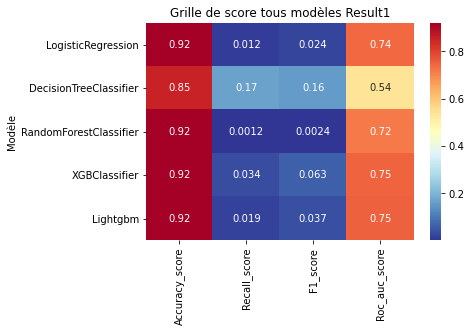

In [48]:
results_1.set_index('Modèle', inplace = True)
sns.heatmap(results_1, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Grille de score tous modèles Result1')
plt.savefig(chemin_graph+"Grille de score tous modèles paramètre défaut = Result1", dpi=400,bbox_inches='tight', pad_inches=0.5)

# scoring_2 - Modèles avec grille de paramètres sur jeu de training <a class="anchor" id="chapter7"></a>

In [59]:
results_2=pd.DataFrame({})

In [60]:
temps0=time.time()
# entrainement de nos modéles

scoring_2=learning(log_grid, X_train, y_train, X_test, y_test)
results_2 = results_2.append(pd.DataFrame({
    'Modèle' : ['LogisticRegression'],
    'Accuracy_score' :scoring_2[0],
    'Recall_score' :scoring_2[1],
    'F1_score' :scoring_2[2],
    'Roc_auc_score' :scoring_2[3]}),
  
ignore_index=True)
scoring_2=learning(tree_grid, X_train, y_train, X_test, y_test)
results_2 = results_2.append(pd.DataFrame({
    'Modèle' : ['DecisionTreeClassifier'],
    'Accuracy_score' :scoring_2[0],
    'Recall_score' :scoring_2[1],
    'F1_score' :scoring_2[2],
    'Roc_auc_score' :scoring_2[3]}),
  
ignore_index=True)
scoring_2=learning(random_forest_grid, X_train, y_train, X_test, y_test)
results_2 = results_2.append(pd.DataFrame({
    'Modèle' : ['RandomForestClassifier'],
    'Accuracy_score' :scoring_2[0],
    'Recall_score' :scoring_2[1],
    'F1_score' :scoring_2[2],
    'Roc_auc_score' :scoring_2[3]}),
  
ignore_index=True)
scoring_2=learning(xgb_grid, X_train, y_train, X_test, y_test)
results_2 = results_2.append(pd.DataFrame({
    'Modèle' : ['XGBClassifier'],
    'Accuracy_score' :scoring_2[0],
    'Recall_score' :scoring_2[1],
    'F1_score' :scoring_2[2],
    'Roc_auc_score' :scoring_2[3]}),
  
ignore_index=True)
scoring_2=learning(lightgbm_grid, X_train, y_train, X_test, y_test)
results_2 = results_2.append(pd.DataFrame({
    'Modèle' : ['Lightgbm'],
    'Accuracy_score' :scoring_2[0],
    'Recall_score' :scoring_2[1],
    'F1_score' :scoring_2[2],
    'Roc_auc_score' :scoring_2[3]}),
  
ignore_index=True)

duration0=time.time()-temps0
print("Temps entrainement de nos modéles - result2 : ", "%15.2f" % duration0, "secondes")

[14:35:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:10:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:13:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:14:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:44:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:45:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [61]:
results_2

Modèle  Accuracy_score  Recall_score  F1_score  \
0      LogisticRegression        0.919331      0.013292  0.025916   
1  DecisionTreeClassifier        0.919190      0.005639  0.011142   
2  RandomForestClassifier        0.919266      0.000000  0.000000   
3           XGBClassifier        0.919548      0.019334  0.037354   
4                Lightgbm        0.919624      0.017857  0.034631   

   Roc_auc_score  
0       0.742911  
1       0.713811  
2       0.733055  
3       0.754386  
4       0.753501

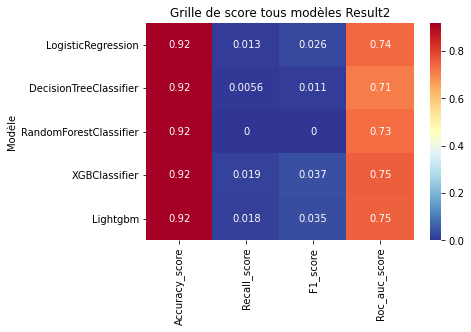

In [52]:
results_2.set_index('Modèle', inplace = True)
sns.heatmap(results_2, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Grille de score tous modèles Result2')
plt.savefig(chemin_graph+"Grille de score tous modèles paramètres optimisés = Result2", dpi=400,bbox_inches='tight', pad_inches=0.5)

# scoring_3 - Modèles avec grille de paramètre avec jeu de training et undersampling <a class="anchor" id="chapter8"></a>

* Le sous-échantillonnage aléatoire (random undersampling) des observations majoritaires : on retire aléatoirement des observations majoritaires
* Le sur-échantillonnage aléatoire (random oversampling) des observations minoritaires : on tire au hasard des individus minoritaires que l’on rajoute aux données.

In [56]:
#from collections import Counter
#from sklearn.datasets import make_classification
#from imblearn.under_sampling import RandomUnderSampler
#from sklearn.model_selection import StratifiedKFold
#from imblearn.metrics import classification_report_imbalanced

In [63]:
def underSampler (model, X_train, y_train, X_test, y_test):
    
    rUs = RandomUnderSampler()
    X_ru, y_ru = rUs.fit_resample(X_train, y_train)
    # Entraînement du modèle 
    clf=model.fit(X_ru, y_ru)
    
    #results_2=[]
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)

    test_accu = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_proba[:, 1])
#     best_param=clf.best_params_
#     best_score=clf.best_score_
#     best_estimator=clf.best_estimator_
    
#     results.append(test_accu, test_recall, test_f1, test_roc_auc, best_param,best_score,best_estimator)
    
    print(confusion_matrix(y_test, y_pred))
    print("Taille du jeu d'essai undersamplé : ", "X_ru ", X_ru, " y_ru ", y_ru)
    
    return test_accu, test_recall, test_f1, test_roc_auc #, best_param,best_score,best_estimator
    

In [64]:
scoring_3=underSampler(log_grid, X_train, y_train, X_test, y_test)

[[58278 26528]
 [ 2471  4977]]
Taille du jeu d'essai undersamplé :  X_ru  [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]  y_ru  0        0
1        0
2        0
3        0
4        0
        ..
34749    1
34750    1
34751    1
34752    1
34753    1
Name: TARGET, Length: 34754, dtype: int64


In [66]:
# A exécuter
results_3=pd.DataFrame({})

In [67]:
temps0=time.time()
# entrainement de nos modéles

scoring_3=underSampler(log_grid, X_train, y_train, X_test, y_test)
#Xsmall_train, ysmall_train, X_test, y_test)
results_3 = results_3.append(pd.DataFrame({
    'Modèle' : ['LogisticRegression'],
    'Accuracy_score' :scoring_3[0],
    'Recall_score' :scoring_3[1],
    'F1_score' :scoring_3[2],
    'Roc_auc_score' :scoring_3[3]}),
  
ignore_index=True)
scoring_3=underSampler(tree_grid, X_train, y_train, X_test, y_test)
results_3 = results_3.append(pd.DataFrame({
    'Modèle' : ['DecisionTreeClassifier'],
    'Accuracy_score' :scoring_3[0],
    'Recall_score' :scoring_3[1],
    'F1_score' :scoring_3[2],
    'Roc_auc_score' :scoring_3[3]}),
  
ignore_index=True)
scoring_3=underSampler(random_forest_grid, X_train, y_train, X_test, y_test)
results_3 = results_3.append(pd.DataFrame({
    'Modèle' : ['RandomForestClassifier'],
    'Accuracy_score' :scoring_3[0],
    'Recall_score' :scoring_3[1],
    'F1_score' :scoring_3[2],
    'Roc_auc_score' :scoring_3[3]}),
  
ignore_index=True)
scoring_3=underSampler(xgb_grid, X_train, y_train, X_test, y_test)
results_3 = results_3.append(pd.DataFrame({
    'Modèle' : ['XGBClassifier'],
    'Accuracy_score' :scoring_3[0],
    'Recall_score' :scoring_3[1],
    'F1_score' :scoring_3[2],
    'Roc_auc_score' :scoring_3[3]}),
  
ignore_index=True)
scoring_3=underSampler(lightgbm_grid, X_train, y_train, X_test, y_test)
results_3 = results_3.append(pd.DataFrame({
    'Modèle' : ['Lightgbm'],
    'Accuracy_score' :scoring_3[0],
    'Recall_score' :scoring_3[1],
    'F1_score' :scoring_3[2],
    'Roc_auc_score' :scoring_3[3]}),
  
ignore_index=True)

duration0=time.time()-temps0
print("Temps entrainement de nos modéles param & undersampling - result3 : ", "%15.2f" % duration0, "secondes")

[[58149 26657]
 [ 2456  4992]]
Taille du jeu d'essai undersamplé :  X_ru  [[0. 1. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]  y_ru  0        0
1        0
2        0
3        0
4        0
        ..
34749    1
34750    1
34751    1
34752    1
34753    1
Name: TARGET, Length: 34754, dtype: int64
[[56120 28686]
 [ 2564  4884]]
Taille du jeu d'essai undersamplé :  X_ru  [[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]  y_ru  0        0
1        0
2        0
3        0
4        0
        ..
34749    1
34750    1
34751    1
34752    1
34753    1
Name: TARGET, Length: 34754, dtype: int64
[[57401 27405]
 [ 2426  5022]]
Taille du jeu d'essai undersamplé :  X_ru  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 0. 

[17:30:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:31:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[17:36:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Regardons l'effet de notre correction de classe sur nos scoring:

In [68]:
results_3

Modèle  Accuracy_score  Recall_score  F1_score  \
0      LogisticRegression        0.684426      0.670247  0.255365   
1  DecisionTreeClassifier        0.661261      0.655747  0.238139   
2  RandomForestClassifier        0.676643      0.674275  0.251887   
3           XGBClassifier        0.687526      0.682197  0.260638   
4                Lightgbm        0.690236      0.681257  0.262053   

   Roc_auc_score  
0       0.742349  
1       0.709824  
2       0.738185  
3       0.751079  
4       0.751211

In [58]:
results_3_sv=results_3.copy()

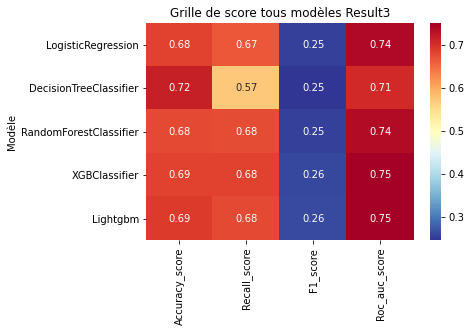

In [59]:
results_3.set_index('Modèle', inplace = True)
sns.heatmap(results_3, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Grille de score tous modèles Result3')
plt.savefig(chemin_graph+"Grille score tous modèles param optimisés & undersampling = Result3", dpi=400,bbox_inches='tight', pad_inches=0.5)

In [60]:
results_3_newindex=results_3.copy()

In [61]:
results_3=results_3_sv.copy()

In [62]:
results_3

Modèle  Accuracy_score  Recall_score  F1_score  \
0      LogisticRegression        0.684415      0.667159  0.254481   
1  DecisionTreeClassifier        0.715828      0.572771  0.245539   
2  RandomForestClassifier        0.679634      0.677497  0.254546   
3           XGBClassifier        0.685401      0.684076  0.259863   
4                Lightgbm        0.690268      0.679108  0.261463   

   Roc_auc_score  
0       0.740630  
1       0.706095  
2       0.737797  
3       0.750544  
4       0.750881

# Validation et choix des 2 meilleurs modéles <a class="anchor" id="section_8_1"></a>

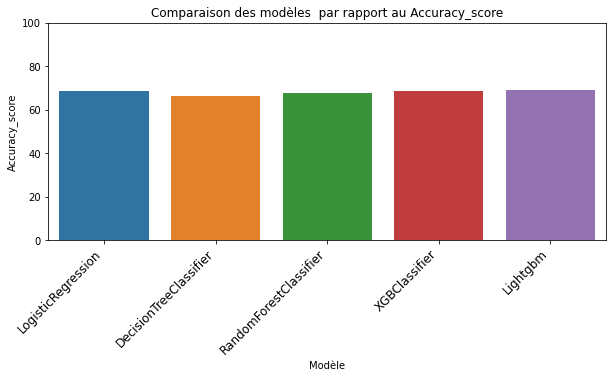

In [69]:
plt.figure(figsize=(10,4))
plt.title('Comparaison des modèles  par rapport au Accuracy_score')
chart = sns.barplot(x = results_3['Modèle'],
           y = results_3['Accuracy_score']*100)
chart.set_xticklabels(labels = results_3['Modèle'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 100])
plt.savefig(chemin_graph+"Accuracy_score_ts_modèles - result3", dpi=400,bbox_inches='tight', pad_inches=0.5)
plt.show()

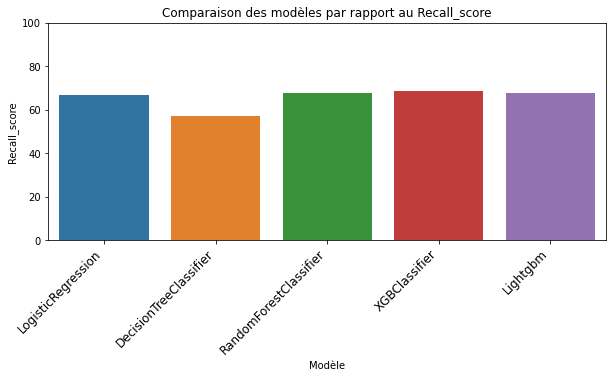

In [64]:
#Accuracy_score	Recall_score	F1_score
plt.figure(figsize=(10,4))
plt.title('Comparaison des modèles par rapport au Recall_score')
chart = sns.barplot(x = results_3['Modèle'],
           y = results_3['Recall_score']*100)
chart.set_xticklabels(labels = results_3['Modèle'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 100])
plt.savefig(chemin_graph+"Recall_score_ts_modèles - result3", dpi=400,bbox_inches='tight', pad_inches=0.5)
plt.show()

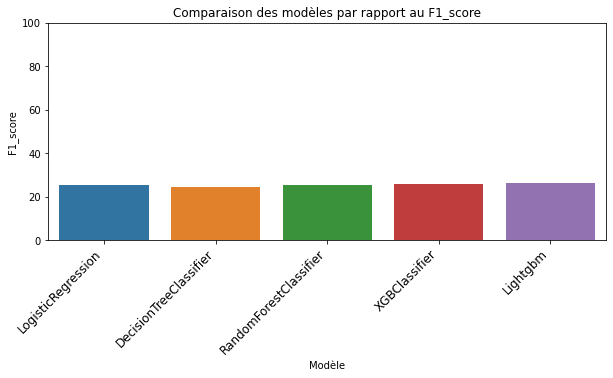

In [65]:
#Accuracy_score	Recall_score	F1_score
plt.figure(figsize=(10,4))
plt.title('Comparaison des modèles par rapport au F1_score')
chart = sns.barplot(x = results_3['Modèle'],
           y = results_3['F1_score']*100)
chart.set_xticklabels(labels = results_3['Modèle'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 100])
plt.savefig(chemin_graph+"F1_score_ts_modèles  - result3", dpi=400,bbox_inches='tight', pad_inches=0.5)
plt.show()

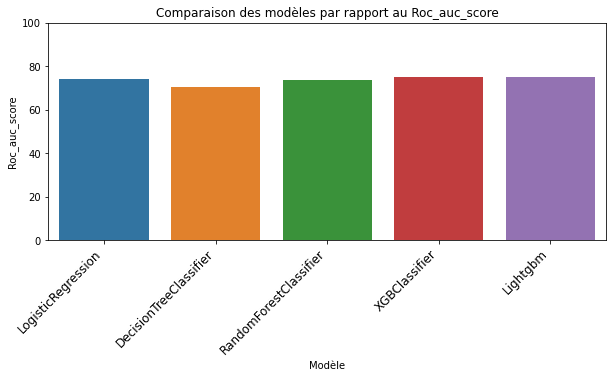

In [66]:
#Accuracy_score	Recall_score	F1_score
plt.figure(figsize=(10,4))
plt.title('Comparaison des modèles par rapport au Roc_auc_score')
chart = sns.barplot(x = results_3['Modèle'],
           y = results_3['Roc_auc_score']*100)
chart.set_xticklabels(labels = results_3['Modèle'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
ax.set_ylim([0, 100])
plt.savefig(chemin_graph+"Roc_auc_score_ts_modèles  - result3", dpi=400,bbox_inches='tight', pad_inches=0.5)
plt.show()

En se basant sur l'optimisation de grid search cv, par rapport au scores : [ROC AUC et Métrique bancaire], les modèles retenus sont les suivants : 'XGBClassifier' et LGBMClassifier

In [70]:
print("Taille de l'app_train :", app_train.shape)
print("Taille de l'app_train :", app_test.shape)
print("Type de l'app_train :", type(app_train))
print("Taille de l'app_train :", type(app_test))

Taille de l'app_train : (307511, 198)
Taille de l'app_train : (48744, 197)
Type de l'app_train : <class 'pandas.core.frame.DataFrame'>
Taille de l'app_train : <class 'pandas.core.frame.DataFrame'>


## Création de 2 dataframes spécifique domain <a class="anchor" id="chapter9"></a>
* app_train_domain à partir de app_train
* app_test_domain à partir de app_test

### Feature Engineering <a class="anchor" id="section_9_1"></a>

In [27]:
# A exécuter pour la suite
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

In [28]:
# A exécuter pour la suite
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [29]:
# A exécuter pour la suite
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [30]:
print("Taille de l'app_train_domain :", app_train_domain.shape)
print("Taille de l'app_train_test :", app_test_domain.shape)
print("Type de l'app_train_domain :", type(app_train_domain))
print("Taille de l'app_test_domain :", type(app_test_domain))

Taille de l'app_train_domain : (307511, 202)
Taille de l'app_train_test : (48744, 201)
Type de l'app_train_domain : <class 'pandas.core.frame.DataFrame'>
Taille de l'app_test_domain : <class 'pandas.core.frame.DataFrame'>


##### Sauvegarde 3
app_train_domain
app_test_domain

#### Sauvegarde des dataframes domaines
* la dataframe app_train_domain contient 'TARGET' 

In [31]:
app_train_domain_sv=app_train_domain.copy()
app_test_domain_sv=app_test_domain.copy() 

#### Restauration des dataframes domaines si nécésssaire (mise au point)

In [37]:
app_train_domain=app_train_domain_sv.copy()
app_test_domain=app_test_domain_sv.copy() 

#### --------------------------------------------------------------------------------------

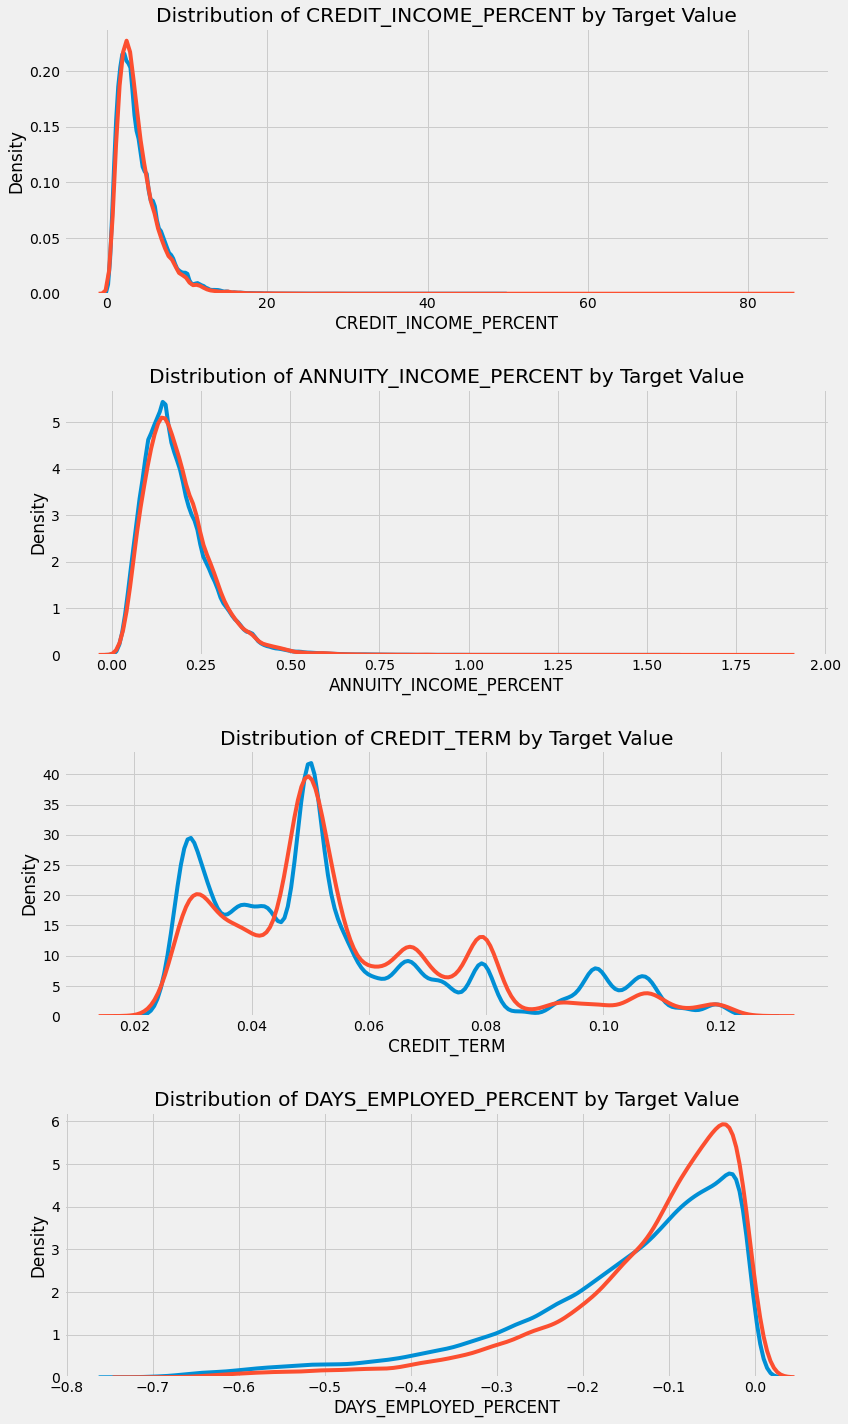

In [62]:
# Exécution optionnelle une seconde fois
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.savefig(chemin_graph+'Distribution of %s by Target Value' % feature, dpi=400,bbox_inches='tight', pad_inches=0.5)    
plt.tight_layout(h_pad = 2.5)

# Pour passer à l'étape scoring 4 et 5
* [Modélisation DataFrame Domain](#chapter11)

# Création des dataframes Train et Test après normalisation des données <a class="anchor" id="chapter10"></a>

Taille de l'app_train : (307511, 198)
Taille de l'app_train : (48744, 197)

In [37]:
app_train.head(5)

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0             0                1   
1      100003                   0             0                0   
2      100004                   1             1                1   
3      100006                   0             0                1   
4      100007                   0             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   
3                    0.008019       19005        -3039.0            -9833.0   
4                    0.028663       19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0      0.262949      0.139376                       2.0   
1      0.622246           NaN                   

### Création des datas 'train' et 'test' normalisés sans Target et sans SK_ID_CURR <a class="anchor" id="section_8_1"></a>

In [33]:

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Copy of the testing data
test = app_test.copy()

train=train.drop(columns = ['SK_ID_CURR'])
test=test.drop(columns = ['SK_ID_CURR'])
    
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 196)
Testing data shape:  (48744, 196)


In [64]:
app_train.head(5)

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0             0                1   
1      100003                   0             0                0   
2      100004                   1             1                1   
3      100006                   0             0                1   
4      100007                   0             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   
3                    0.008019       19005        -3039.0            -9833.0   
4                    0.028663       19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0      0.262949      0.139376                       2.0   
1      0.622246           NaN                   

In [78]:
# # # Extract feature importances
# feature_importance_values = random_forest_domain.feature_importances_
# feature_importances = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values})

In [45]:
app_train_domain

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002                   0             0                1   
1           100003                   0             0                0   
2           100004                   1             1                1   
3           100006                   0             0                1   
4           100007                   0             0                1   
...            ...                 ...           ...              ...   
307506      456251                   0             0                0   
307507      456252                   0             0                1   
307508      456253                   0             0                1   
307509      456254                   0             0                1   
307510      456255                   0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801        9461   
1             1129500.0                    0.003541       16765   
2              135000.0                    0.010032       19046   
3              297000.0                    0.008019       19005   
4              513000.0                    0.028663       19932   
...                 ...                         ...         ...   
307506         225000.0                    0.032561        9327   
307507         225000.0                    0.025164       20775   
307508         585000.0                    0.005002       14966   
307509         319500.0                    0.005313       11961   
307510         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0              -637.0            -3648.0            -2120          NaN   
1             -1188.0            -1186.0             -291          NaN   
2              -225.0            -4260.0            -2531         26.0   
3             -3039.0            -9833.0            -2437          NaN   
4             -3038.0            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
307506         -236.0            -8456.0            -1982          NaN   
307507            NaN            -4388.0            -4090          NaN   
307508        -7921.0            -6737.0            -5150          NaN   
307509        -4786.0            -2562.0             -931          NaN   
307510        -1262.0            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
307506           1               1                0                 1   
307507           1               0              

In [8]:
#print('app_train_domain contient TARGET',sum(app_train_domain.columns=='TARGET'))

In [9]:
#app_train_domain.info(verbose=True, buf=None, max_cols=None, memory_usage=None, show_counts=True, null_counts=None)

In [10]:
#app_test_domain

In [11]:
#app_test_domain.info(verbose=True, buf=None, max_cols=None, memory_usage=None, show_counts=True, null_counts=None)

# Normalisation des données dataframes domaines pour le déploiement <a class="anchor" id="section_10_1"></a>
En entrée DataFrame Domain

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

In [80]:
sum(app_train_domain.columns=='SK_ID_CURR')

1

#### Normalisation des dataframes "app_train_domain" et  " "app_test_domain" pour le déploiement

In [29]:
df_train=app_train_domain.set_index('SK_ID_CURR')

In [46]:
df_train

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100002                       0             0                1             0   
100003                       0             0                0             0   
100004                       1             1                1             0   
100006                       0             0                1             0   
100007                       0             0                1             0   
...                        ...           ...              ...           ...   
456251                       0             0                0             0   
456252                       0             0                1             0   
456253                       0             0                1             0   
456254                       0             0                1             0   
456255                       0             0                0             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456251              157500.0    254700.0      27558.0         225000.0   
456252               72000.0    269550.0      12001.5         225000.0   
456253              153000.0    677664.0      29979.0         585000.0   
456254              171000.0    370107.0      20205.0         319500.0   
456255              157500.0    675000.0      49117.5         675000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
SK_ID_CURR                                          ...   
100002                        0.018801        9461  ...   
100003                        0.003541       16765  ...   
100004                        0.010032       19046  ...   
100006                        0.008019       19005  ...   
100007                        0.028663       19932  ...   
...                                ...         ...  ...   
456251                        0.032561        9327  ...   
456252                        0.025164       20775  ...   
456253                        0.005002       14966  ...   
456254                        0.005313       11961  ...   
456255                        0.046220       16856  ...   

            WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
SK_ID_CURR                                                               
100002                                    1                          0   
100003                                    0                          0   
100004                                    0                          0   
100006                                    0                          0   
100007                                    0                          0   
...                                     ...                        ...   
456251                                    1                          0   
456252                                    1                          0   
456253                                    0                          0   
456254                                    1                          0   
456255                                    0                          0   

            EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  TARGET  \
SK_ID_CURR                                                            
100002                           1                        0       1   
100003                           1                        0       0   
100004

In [30]:
df_train= app_train_domain.drop(columns = 'TARGET',axis=1)
df_train=df_train.set_index('SK_ID_CURR')

In [12]:
#df_train

In [32]:
df_test=app_test_domain.set_index('SK_ID_CURR')

lst_col_ssid_train=df_train.columns
lst_col_ssid_test=df_test.columns

In [93]:
#sum(app_train_domain.columns=='TARGET')

In [13]:
#sum(df_train.columns=='TARGET')

In [15]:
#print('Taille df_train',df_train.shape)
#print('Taille df_test',df_test.shape)

In [96]:
#df_test

In [34]:
# Impute the domainnomial features
imputer = SimpleImputer(strategy = 'median')

domain_features_2 = imputer.fit_transform(df_train[lst_col_ssid_train])
domain_features_test_2 = imputer.transform(df_test[lst_col_ssid_test])

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features_2 = scaler.fit_transform(domain_features_2)
domain_features_test_2 = scaler.fit_transform(domain_features_test_2)

app_train_domain_norm=pd.DataFrame(domain_features_2, index=df_train.index, columns=lst_col_ssid_train)
app_test_domain_norm=pd.DataFrame(domain_features_test_2, index=df_test.index, columns=lst_col_ssid_test)

In [14]:
#app_train_domain_norm

In [35]:
print('app_train_domain_norm shape: ', app_train_domain_norm.shape)
print('app_test_domain_norm shape: ', app_test_domain_norm.shape)
print('Type app_train_domain_norm : ', type(app_train_domain_norm))
print('Type app_test_domain_norm : ', type(app_test_domain_norm))

app_train_domain_norm shape:  (307511, 200)
app_test_domain_norm shape:  (48744, 200)
Type app_train_domain_norm :  <class 'pandas.core.frame.DataFrame'>
Type app_test_domain_norm :  <class 'pandas.core.frame.DataFrame'>


In [36]:
app_test_domain_norm

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100001                     0.0           0.0              1.0          0.00   
100005                     0.0           0.0              1.0          0.00   
100013                     0.0           1.0              1.0          0.00   
100028                     0.0           0.0              1.0          0.10   
100038                     0.0           1.0              0.0          0.05   
...                        ...           ...              ...           ...   
456221                     0.0           0.0              1.0          0.00   
456222                     0.0           0.0              0.0          0.10   
456223                     0.0           1.0              1.0          0.05   
456224                     0.0           0.0              0.0          0.00   
456250                     0.0           1.0              0.0          0.00   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100001              0.024654    0.238037     0.102453         0.184049   
100005              0.016440    0.080785     0.084558         0.061350   
100013              0.040054    0.280965     0.378515         0.265849   
100028              0.065721    0.695297     0.262078         0.695297   
100038              0.034920    0.263804     0.166995         0.263804   
...                      ...         ...          ...              ...   
456221              0.021574    0.167035     0.085138         0.102249   
456222              0.029787    0.262401     0.166111         0.204499   
456223              0.040054    0.122699     0.173381         0.122699   
456224              0.045187    0.184049     0.128073         0.184049   
456250              0.024654    0.121685     0.125726         0.102249   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100001                        0.257380    0.333427       0.866682   
100005                        0.491855    0.399339       0.744130   
100013                        0.260854    0.288794       0.744760   
100028                        0.361760    0.628269       0.893197   
100038                        0.135340    0.680685       0.874585   
...                                ...         ...            ...   
456221                        0.024760    0.292602       0.704043   
456222                        0.491855    0.784510       0.934257   
456223                        0.361760    0.519292       0.826137   
456224                        0.257380    0.628717       0.843661   
456250                        0.088243    0.629053       0.963807   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100001               0.782059         0.872086     0.121622         1.0   
100005               0.615631         0.744329     0.121622         1.0   
100013               0.908313         0.448173     0.067568         1.0   
100028               0.915690         0.337114     0.121622         1.0   
100038               0.831380         0.328607     0.216216         1.0   
...                       ...              ...          ...         ...   
456221               0.616643         0.464556     0.121622         1.0   
456222               0.872903         0.526938     0.121622         1.0   
456223               0.886983         0.763075     0.054054         1.0   
456224               0.938412         0.785129     0.121622         1.0   
456250               0.954810         0.335224     0.297297         1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                            

#### Réindexation avant sauvegardes sur disque

##### Sauvegarde mémoire

In [77]:
#app_train_domain_norm_sv=app_train_domain_norm.copy()
#app_test_domain_norm_sv=app_test_domain_norm.copy()

##### Restauration mémoire

In [35]:
#app_train_domain_norm=app_train_domain_norm_sv.copy()
#app_test_domain_norm=app_test_domain_norm_sv.copy()

In [16]:
#sum(app_train_domain_norm.columns=='TARGET')
#sum(df_train.columns=='TARGET')

In [55]:
#rajout de la colonne TARGET pour example
#app_domain=pd.concat([app_train_domain, app_test_domain], ignore_index=True)
#app_train_domain_norm_essai=pd.concat([app_train_domain_norm, TARGET])
app_train_domain_norm_essai = app_train_domain_norm.assign(TARGET = TARGET[:])

In [56]:
#app_train_domain_norm_essai.iloc[:,-1:]
app_train_domain_norm_essai.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

##### Pour le déploiement Heroku il faut un fichier de test léger en taille (1000 enregistrements)

In [38]:
app_test_domain_norm_reduit=app_test_domain_norm.sample(1000)

In [40]:
# A exécuter
#app_train_domain_norm.to_pickle("C:/Users/User/Documents/OpenClassroom/Projet7/Data/app_train_domain_norm_idx")
#app_test_domain_norm.to_pickle("C:/Users/User/Documents/OpenClassroom/Projet7/Data/app_test_domain_norm_idx")
#app_test_domain_norm_reduit.to_csv('app_test_domain_norm_idx.csv', index=True)
app_test_domain_norm_reduit.to_csv('app_test_domain_norm_idx.csv')

In [63]:
app_train_domain_norm=app_train_domain_norm.reset_index() 
app_test_domain_norm=app_test_domain_norm.reset_index() 

##### Fin normalisation pour sauvegarde externe

## Modélisation DataFrame Domain <a class="anchor" id="chapter11"></a>

In [32]:
# Optionnel si pas de sauvegarde pour déploiement
app_train_domain_sv2=app_train_domain.copy()
app_test_domain_sv2=app_test_domain.copy()

In [91]:
#app_train_domain=app_train_domain_sv2.copy()
#app_test_domain=app_test_domain_sv2.copy()

In [33]:
#domain_features
app_train_domain = app_train_domain.drop(columns = 'TARGET')
app_train_domain = app_train_domain.drop(columns = 'SK_ID_CURR')
app_test_domain = app_test_domain.drop(columns = 'SK_ID_CURR')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

#print('Type domain_features ap imputer : ', type(domain_features))
#print('Type domain_features_test ap imputer : ', type(domain_features_test))

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

En entrée liste de données normalisées
domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

In [34]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [192]:
#poly_features.shape,app_train_domain.shape,domain_features.shape

((307511, 166), (307511, 201), (307511, 201))

In [80]:
app_train_domain.shape,domain_features.shape

((307511, 200), (307511, 200))

In [193]:
#type(poly_features),type(app_train_domain),type(domain_features)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame, numpy.ndarray)

In [118]:
type(app_train_domain),type(domain_features),type(app_test_domain)

(pandas.core.frame.DataFrame, numpy.ndarray, pandas.core.frame.DataFrame)

In [35]:
#A exécuter
X2 = domain_features #domain_features
y2 = train_labels

from sklearn.model_selection import train_test_split
X2_train_domain, X2_test_domain, y2_train_domain, y2_test_domain = \
                        train_test_split(X2, 
                                         y2,  
                                         test_size = 0.5,# stratify à rajouter pour garder la notion de 90%  
                                         random_state=5,
                                         stratify=y2
                                        )

In [82]:
print(X2_train_domain.shape)
print(X2_test_domain.shape)

(153755, 200)
(153756, 200)


In [83]:
#print(type(X2_train_domain))
#print(type(X2_test_domain))

## Pour gain de temps pour la mise au point on peut passer directement à l'étape :
* [Création metric client & des 2 meilleurs modèles](#chapter12)

## scoring_4 - 2 meilleurs modèles avec grille de paramètre avec jeu de training (DataFrame training) sur Dataframe domain et undersampling <a class="anchor" id="section_11_1"></a>

In [84]:
# A exécuter - impératif
results_4=pd.DataFrame({})

In [85]:
# A exécuter - impératif
def learning_2(model, X2_train_domain, y2_train_domain, X2_test_domain, y_test_domain):
    
    rUs = RandomUnderSampler()
    X_ru, y_ru = rUs.fit_resample(X2_train_domain, y2_train_domain)
    # Entraînement du modèle 
    clf=model.fit(X_ru, y_ru)
    
    #results_2=[]
    y_pred = clf.predict(X2_test_domain)
    y_proba = clf.predict_proba(X2_test_domain)

    test_accu = accuracy_score(y_test_domain, y_pred)
    test_recall = recall_score(y_test_domain, y_pred)
    test_f1 = f1_score(y_test_domain, y_pred)
    test_roc_auc = roc_auc_score(y_test_domain, y_proba[:, 1])

    print(confusion_matrix(y_test_domain, y_pred))
    
    return test_accu, test_recall, test_f1, test_roc_auc #,#best_param,best_score,best_estimator
    

In [86]:
# entrainement de nos modéles
temps0=time.time()

scoring_4=learning_2(log_grid, X2_train_domain, y2_train_domain, X2_test_domain, y2_test_domain)
results_4 = results_4.append(pd.DataFrame({
    'Modèle' : ['XGBClassifier'],
    'Accuracy_score' :scoring_4[0],
    'Recall_score' :scoring_4[1],
    'F1_score' :scoring_4[2],
    'Roc_auc_score' :scoring_4[3]}),
  
ignore_index=True)
duration0=time.time()-temps0
print("Temps entrainement de nos modéles param & undersampling - result4 : ", "%15.2f" % duration0, "secondes")

[[97260 44083]
 [ 4102  8311]]
Temps entrainement de nos modéles param & undersampling - result4 :            23.54 secondes


In [90]:
# Le 27/01/2022 - le XGBClassifier a obtenu un meilleur score
# entrainement de nos modéles
#temps0=time.time()

#scoring_4=learning_2(log_grid, X2_train_domain, y2_train_domain, X2_test_domain, y2_test_domain)
#results_4 = results_4.append(pd.DataFrame({
#    'Modèle' : ['LogisticRegression'],
#    'Accuracy_score' :scoring_4[0],
#    'Recall_score' :scoring_4[1],
#    'F1_score' :scoring_4[2],
#    'Roc_auc_score' :scoring_4[3]}),
  
#ignore_index=True)

#duration0=time.time()-temps0
#print("Temps entrainement de nos modéles param & undersampling - result4 : ", "%15.2f" % duration0, "secondes")

In [87]:
temps0=time.time()
scoring_4=learning_2(lightgbm_grid, X2_train_domain, y2_train_domain, X2_test_domain, y2_test_domain)
results_4 = results_4.append(pd.DataFrame({
    'Modèle' : ['Lightgbm'],
    'Accuracy_score' :scoring_4[0],
    'Recall_score' :scoring_4[1],
    'F1_score' :scoring_4[2],
    'Roc_auc_score' :scoring_4[3]}),
  
ignore_index=True)

duration0=time.time()-temps0
print("Temps entrainement de nos modéles Lightgbm param & undersampling - result4 : ", "%15.2f" % duration0, "secondes")

[[97795 43548]
 [ 3930  8483]]
Temps entrainement de nos modéles Lightgbm param & undersampling - result4 :            55.89 secondes


In [88]:
results_3

Modèle  Accuracy_score  Recall_score  F1_score  \
0      LogisticRegression        0.684426      0.670247  0.255365   
1  DecisionTreeClassifier        0.661261      0.655747  0.238139   
2  RandomForestClassifier        0.676643      0.674275  0.251887   
3           XGBClassifier        0.687526      0.682197  0.260638   
4                Lightgbm        0.690236      0.681257  0.262053   

   Roc_auc_score  
0       0.742349  
1       0.709824  
2       0.738185  
3       0.751079  
4       0.751211

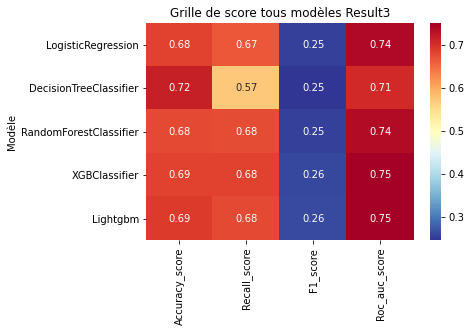

In [90]:
#results_3_newindex.set_index('Modèle', inplace = True)
sns.heatmap(results_3_newindex, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Grille de score tous modèles Result3')
plt.savefig(chemin_graph+"Grille score tous modèles param optimisés & undersampling = Result3", dpi=400,bbox_inches='tight', pad_inches=0.5)

Reprenons nos scores précédents sur un target cible ci-dessus, comparons avec nos score l'ensemble des hyperparamétres (gridsearchCV, correction sur le désiquilibre des classe) avec nos resultats poly feature ci-dessous

Tableau résultast sur les features ingenering 

In [89]:
results_4

Modèle  Accuracy_score  Recall_score  F1_score  Roc_auc_score
0  XGBClassifier        0.686614      0.669540  0.256485       0.744076
1       Lightgbm        0.691212      0.683396  0.263267       0.754339

Nous voyons bien qu'en rajoutant d'autres valeurs cible nous améliorons nos scores et pouvons en déduire quecela permet de mieux optimiser notre modéle de prédiction en prenant en compte d'autres facteurs

In [92]:
#A exécuter
results_4_sv=results_4.copy()

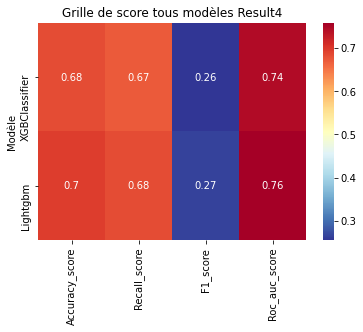

In [93]:
results_4.set_index('Modèle', inplace = True)
sns.heatmap(results_4, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Grille de score tous modèles Result4')
plt.savefig(chemin_graph+"Grille score 2 meilleurs modèles param optimisés = Result4", dpi=400,bbox_inches='tight', pad_inches=0.5)

In [94]:
results_4_newindex=results_4.copy()
results_4=results_4_sv.copy()

# Création metric client & des 2 meilleurs modèles <a class="anchor" id="chapter12"></a>

In [36]:
from sklearn.metrics import make_scorer, fbeta_score
ftwo_scorer = make_scorer(fbeta_score, beta=2)

#### Création XGBClassifier 2 scores

-----------LogisticRegression a perdu sa position au profit de XGBClassifier -----------------

In [210]:
#log_reg = LogisticRegression() # learning modéle de LogisticRegression

#param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} # nos best paramétre pour le modéle

# avec nos meilleurs paramétres
#log_reg_fbetascore=GridSearchCV(log_reg, param_grid, cv=5, scoring=ftwo_scorer) 

In [37]:
#création du modéle XG boost
xgb = XGBClassifier(n_jobs=-1)

param_grid = {
        'n_estimators' : [100],
        'max_depth': [3, 4, 5, 6],
        'eta': [0.0001, 0.001, 0.01, 0.1]
             }

# avec nos meilleurs paramétres

xgb_fbetascore=GridSearchCV(xgb, param_grid, cv=5, scoring=ftwo_scorer) 

#### Création  LGBMClassifier 2 scores

In [49]:
print(type(xgb_fbetascore))

<class 'sklearn.model_selection._search.GridSearchCV'>


In [38]:
# Création du modéle
lightgbm = lgb.LGBMClassifier()

#avec GridSearchCV scoring=roc_auc
param_grid = { 'n_estimators' : [100], 
               'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
               'max_depth' : [3, 4, 5, 6]
              }
lightgbm_fbetascore=GridSearchCV(lightgbm, param_grid, cv=5, scoring=ftwo_scorer) 

In [39]:
print(type(xgb_fbetascore))
print(type(lightgbm_fbetascore))

<class 'sklearn.model_selection._search.GridSearchCV'>
<class 'sklearn.model_selection._search.GridSearchCV'>


In [40]:
def seuil_searchFbeta_score(model, X2_test_domain, y2_test_domain):
    
    rUs = RandomUnderSampler()
    X_ru, y_ru = rUs.fit_resample(X2_train_domain, y2_train_domain)
    # Entraînement du modèle 
    clf=model.fit(X_ru, y_ru)
    
    thresholds = np.linspace(0.0, 1, 20)
    seuil = []
    
    for th in thresholds:
            y_proba = clf.predict_proba(X2_test_domain)[:,1]
            y_pred = (y_proba>th)*1
            y2_pred=clf.predict(X2_test_domain)
            seuil.append(fbeta_score(y2_test_domain, y_pred,2))
            
            test_accu = accuracy_score(y2_test_domain, y2_pred)
            test_recall = recall_score(y2_test_domain, y2_pred)
            test_f1 = f1_score(y2_test_domain, y2_pred)
            test_roc_auc = roc_auc_score(y2_test_domain, y_proba)
    # Plot  
    plt.plot(thresholds, seuil)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice bancaire")
    plt.xticks(np.linspace(0.1, 1, 10))
    
   #idx_best_th = y_pred.index(max(y_pred))
    #best_th = np.max(y_pred)
    
    #return seuil,test_accu,test_recall,test_f1,test_roc_auc
    return seuil,test_accu,test_recall,test_f1,test_roc_auc,y2_pred

## Scoring 5 - metric client & 2 meilleurs modèles <a class="anchor" id="section_12_1"></a>¶

In [41]:
# A exécuter
results_5=pd.DataFrame({})

#### Scoring 5 avec xgb_fbetascore (xgb = XGBClassifier) <a class="anchor" id="section_12_1_1"></a>

[13:10:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:15:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[13:19:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

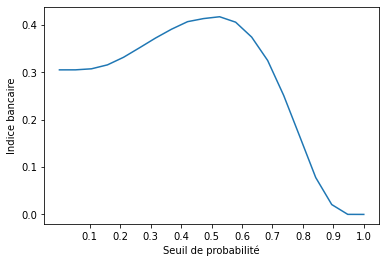

In [42]:
temps0=time.time()
# entrainement de nos modéles

scoring_5=seuil_searchFbeta_score(xgb_fbetascore,X2_test_domain, y2_test_domain)
results_5 = results_5.append(pd.DataFrame({
    'Modèle' : ['XGBClassifier'],
   'Accuracy_score' :scoring_5[1],
    'Recall_score' :scoring_5[2],
    'F1_score' :scoring_5[3],
    'Roc_auc_score' :scoring_5[4]}),
  #  'seuil' :scoring_5[0]}),
  
ignore_index=True)

duration0=time.time()-temps0
print("Temps entrainement de XGBClassifier - result5 : ", "%15.2f" % duration0, "secondes")

In [77]:
# entrainement de nos modéles

#scoring_5=seuil_searchFbeta_score(log_reg_fbetascore,X2_test_domain, y2_test_domain)
#results_5 = results_5.append(pd.DataFrame({
#    'Modèle' : ['LogisticRegression'],
#   'Accuracy_score' :scoring_5[1],
#    'Recall_score' :scoring_5[2],
#    'F1_score' :scoring_5[3],
#    'Roc_auc_score' :scoring_5[4]}),
  #  'seuil' :scoring_5[0]}),
#  
#ignore_index=True)

In [78]:
#log_reg_fbetascore.best_estimator_
#log_reg_fbetascore.best_params_
#log_reg_fbetascore.best_score_

In [125]:
#log_reg_fbetascore.best_params_

In [126]:
#log_reg_fbetascore.best_score_

In [43]:
print(xgb_fbetascore.best_estimator_)
print(xgb_fbetascore.best_params_)
print(xgb_fbetascore.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
{'eta': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.6860002062041196


#### Matrice de confusion (xgb = XGBClassifier) <a class="anchor" id="section_12_1_2"></a>

In [44]:
from sklearn.metrics import confusion_matrix

In [81]:
#conf = confusion_matrix(y2_test_domain, y_predxgb)
#TP = conf[0,0]
#FP = conf[0,1]
#TN = conf[1,0]
#FN = conf[1,1]
#print(TP,FP,TN,FN)

In [45]:
#y_predrandf=scoring_5[5]
y_predxgb=scoring_5[5]

In [105]:
print('Confussion matrix:\n',confusion_matrix(y2_test_domain, y_predxgb))

Confussion matrix:
 [[98626 42717]
 [ 3908  8505]]


In [46]:
def plot_matrx_confusion (data):
    cm_matrix = pd.DataFrame(data, columns=['Predict Positives','Predict Negative'], 
                                     index=['Actual Positives','Actual Negative'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

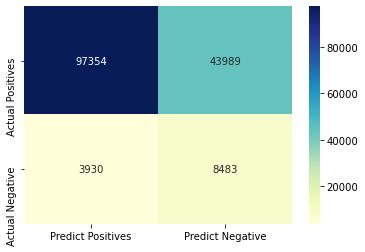

In [47]:
#plot_matrx_confusion (matrix_confusion(y2_test_domain, y_predrandf))
plot_matrx_confusion (confusion_matrix(y2_test_domain, y_predxgb))
plt.savefig(chemin_graph+"Matrice confusion XGBClassifier v2", dpi=400,bbox_inches='tight', pad_inches=0.5)

##### Scoring 5 avec lightgbm_fbetascore <a class="anchor" id="section_12_1_3"></a>

Temps entrainement de lightgbm - result5 :            85.65 secondes


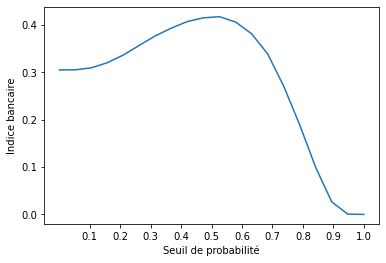

In [48]:
temps0=time.time()
scoring_5=seuil_searchFbeta_score(lightgbm_fbetascore,X2_test_domain, y2_test_domain)
results_5 = results_5.append(pd.DataFrame({
    'Modèle' : ['Lightgbm'],
    'Accuracy_score' :scoring_5[1],
    'Recall_score' :scoring_5[2],
    'F1_score' :scoring_5[3],
    'Roc_auc_score' :scoring_5[4]}),
  
ignore_index=True)

duration0=time.time()-temps0
print("Temps entrainement de lightgbm - result5 : ", "%15.2f" % duration0, "secondes")

In [60]:
print(lightgbm_fbetascore.best_estimator_)
print(lightgbm_fbetascore.best_params_)
print(lightgbm_fbetascore.best_score_)

LGBMClassifier(max_depth=4)
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.6914166973749283


In [50]:
y_predlght=scoring_5[5]

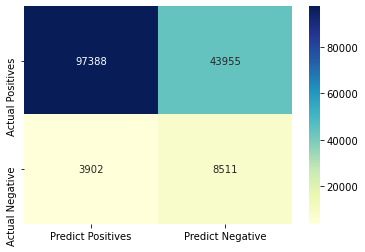

In [51]:
plot_matrx_confusion (confusion_matrix(y2_test_domain, y_predlght))
plt.savefig(chemin_graph+"Matrice confusion Lightbgm V2", dpi=400,bbox_inches='tight', pad_inches=0.5)

In [61]:
results_5

Modèle  Accuracy_score  Recall_score  F1_score  Roc_auc_score
0  XGBClassifier        0.688344      0.683396  0.261478       0.754110
1       Lightgbm        0.688747      0.685652  0.262365       0.754204

In [113]:
def prediction (model, X2_test_domain, y2_test_domain):
    
    y_pred=model.predict(X2_test_domain)
    y_prob = model.predict_proba(X2_test_domain)
    print('Test set score: {:.4f}'.format(model.score( X2_test_domain, y2_test_domain)))
    
    return y_pred,y_prob

In [79]:
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn import metrics

In [116]:
#y_predrandf,y_probasrandf=prediction(log_reg_fbetascore,X2_test_domain, y2_test_domain)
y_predxgb,y_probasxgb=prediction(xgb_fbetascore,X2_test_domain, y2_test_domain)

Test set score: 0.4216


In [83]:
#skplt.metrics.plot_roc_curve(y2_test_domain, y_probasxgb)
#plt.title('ROC-AUC XGBClassifier')
#plt.savefig(chemin_graph+"ROC curve XGBClassifier", dpi=400,bbox_inches='tight', pad_inches=0.5)
#plt.show()

In [118]:
y_predlght,y_probaslght=prediction (lightgbm_fbetascore,X2_test_domain, y2_test_domain)

Test set score: 0.4184


In [82]:
#skplt.metrics.plot_roc_curve(y2_test_domain, y_probaslght)
#skplt.metrics.plot_roc_curve(y2_test_domain, y_probaslght) # 
#plt.title('ROC-AUC Lightbgm')
#plt.savefig(chemin_graph+"ROC curve Lightbgm", dpi=400,bbox_inches='tight', pad_inches=0.5)
#plt.show()

#### Nouveauté au 21/02/2022

In [85]:
def metriques(modeles, clfs, Xtest, ytest): 
        #Métiques utilisées pour les modèles de base
    list_AUC = []
    list_accuracy_score = []
    list_precision =[]
    list_rappel = []
    list_F1_score =[]
    list_F2_score =[]
    
        # calcul des métriques
    fig = plt.figure(figsize=(10, 7))
    for modele,clf in  zip(modeles,clfs):
        #if (modele == 'SVC'):
        #    y_pred_prob = clf.decision_function(Xtest)
        #else:
        y_pred_prob = clf.predict_proba(Xtest)[:,1]    
            
        ypred = clf.predict(Xtest)
        
        list_accuracy_score.append(accuracy_score(ytest, ypred))
        list_precision.append(precision_score(ytest, ypred))
        list_rappel.append(recall_score(ytest, ypred))
        list_F1_score.append(f1_score(ytest, ypred) )
        list_F2_score.append(fbeta_score(ytest, ypred, beta=2) )
        
        taux_faux_positif, taux_vrai_positif, seuils = metrics.roc_curve(ytest, y_pred_prob)
        roc_auc = metrics.auc(taux_faux_positif, taux_vrai_positif)
        list_AUC.append(roc_auc)
        plt.plot(taux_faux_positif, taux_vrai_positif, label = modele +r' AUC = %0.2f' % roc_auc)

    resultModels = {  "Modèle": modeles, 
            "Accuracy" :list_accuracy_score,
            "ROC_AUC": list_AUC, 
            "Précision": list_precision, 
            "Rappel": list_rappel, 
            "F1-score": list_F1_score, 
            "F2_score": list_F2_score
                   }
    resultModels_df = pd.DataFrame(resultModels)
    plt.title('Courbe ROC  ' , fontsize =16)
    plt.xlabel('Taux de faux positifs (1 - Spécificité)', fontsize =14)
    plt.ylabel('Taux de vrais positifs (Sensibilité)', fontsize =14)
    plt.plot([0, 1], [0, 1],linestyle='--')
    #plt.legend(loc = 'lower right')
    #plt.legend(loc = 'upper right')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.savefig(chemin_graph+"ROC curve modèles", dpi=400,bbox_inches='tight', pad_inches=0.5)
    plt.show()
    return resultModels_df

In [73]:
#def prediction (model, X2_test_domain, y2_test_domain):
    
#    y_pred=model.predict(X2_test_domain)
#    y_prob = model.predict_proba(X2_test_domain)
#    print('Test set score: {:.4f}'.format(model.score( X2_test_domain, y2_test_domain)))
    
#    return y_pred,y_prob
#y_predlght,y_probaslght=prediction (lightgbm_fbetascore,X2_test_domain, y2_test_domain)

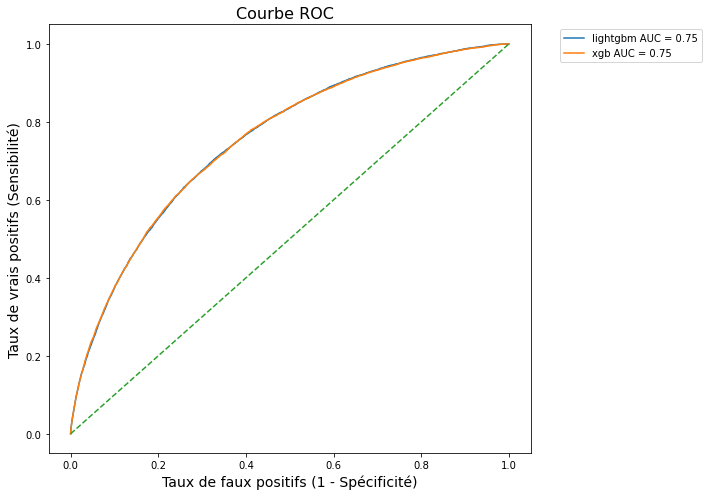

In [86]:
modeles1 = ['lightgbm',      
             'xgb',
           ]

clfs_fs1 = [lightgbm_fbetascore,
            xgb_fbetascore
           ]

met1=metriques(modeles1, clfs_fs1, X2_test_domain, y2_test_domain)

#### Fin nouveauté du 21/02/2022

In [262]:
# #random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# # Train on the training data
# log_reg.fit(domain_features, train_labels)

# # Extract feature importances
# feature_importance_values_domain = log_reg.feature_importances
# feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# # Make predictions on the test data
# predictions = log_reg.predict_proba(domain_features_test)[:, 1]

#### Affichage des features importantes pour le modèle xgb
ERROR : AttributeError: 'XGBClassifier' object has no attribute 'feature_importances'

In [149]:
# Train on the training data
#xgb.fit(domain_features, train_labels)

# # Extract feature importances
#feature_importance_values_domain_xgb = xgb.feature_importances
#feature_importances_domain_xgb = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# # Make predictions on the test data
#predictions_xgb = xgb.predict_proba(domain_features_test)[:, 1]

In [150]:
#Show the feature importances for the default features
#feature_importances_sorted = plot_feature_importances(feature_importances_domain2)

### Affichage des features importantes <a class="anchor" id="section_12_2"></a>

#### Prédiction sur le DataFrame de crédit de test

In [82]:
# Train on the training data
lightgbm.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain2 = lightgbm.feature_importances_
feature_importances_domain2 = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain2})

# Make predictions on the test data
predictions = lightgbm.predict_proba(domain_features_test)[:, 1]

In [68]:
# Train on the training data
#lightgbm_fbetascore.fit(domain_features, train_labels) # Pas de bug

# Extract feature importances
#feature_importance_values_domain2 = lightgbm_fbetascore.feature_importances_
#feature_importances_domain2 = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain2})
#KO AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

# Make predictions on the test data
#predictions = lightgbm_fbetascore.predict_proba(domain_features_test)[:, 1]

In [70]:
#print((domain_features_test)[:, 1])
#print(predictions)

[0. 0. 1. ... 1. 0. 1.]
[0.03761219 0.11795593 0.02165819 ... 0.02260196 0.04375314 0.18829943]


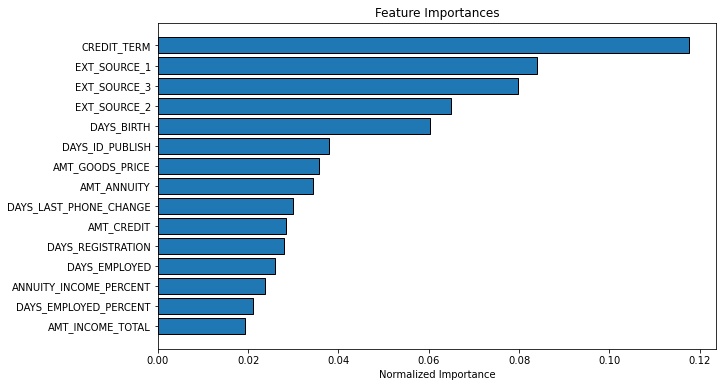

In [121]:
#Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances_domain2)
#plt.savefig(chemin_graph+"Features importantes", dpi=400,bbox_inches='tight', pad_inches=0.5)
#plt.show()

# CONCLUSION

En comparant les performances de deux modèles de classification, on trouve que le Lightgbm est plus performant suivants les différents scores comme la métrique bancaire, le roc et la Fbeta.

Les modèles de Boosting (lgbm) sont particulièrement connus entrainer ce genre de progrès. Ils offrent une précision beaucoup plus élevée et sont plus compatibles avec les grands ensembles de données .

Le features engineerings et une création métrique client permettent de répondre au besoin métier et un score plus optimum et minimiser les erreurs de classification. 

On remarque que le seuil de probabilité permet d'ajuster le scores Fbeta pour les deux modèles.


# Sauvegarde du modèle Lightgbm <a class="anchor" id="chapter13"></a>

In [122]:
filename = 'strealit_model.sav'
joblib.dump(lightgbm_fbetascore, filename)
#joblib.dump(myVar, 'myFile.gz') 

['strealit_model.sav']

# shap <a class="anchor" id="chapter14"></a>

In [65]:
print(lightgbm)

LGBMClassifier()


In [59]:
import shap

shap.initjs()

## shap et lightgbm <a class="anchor" id="section_14_1"></a>

In [62]:
print(lightgbm_fbetascore.best_estimator_)
print(lightgbm_fbetascore.best_params_)
print(lightgbm_fbetascore.best_score_)

LGBMClassifier(max_depth=4)
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.6921905414397985


In [84]:
lightgbm_shap=lgb.LGBMClassifier(max_depth=4,learning_rate=0.1,n_estimators=100)
# Train on the training data
lightgbm_shap.fit(domain_features, train_labels)

LGBMClassifier(max_depth=4)

In [88]:
#TreeExplainer
explainer_2 = shap.TreeExplainer(lightgbm_shap,X2_test_domain)
shap_values = explainer_2.shap_values(X2_test_domain)
#NotFittedError: No classes found. Need to call fit beforehand.
#strealit_model_shap.sav

100%|===================| 153540/153756 [06:56<00:00]        

In [4]:
#print(explainer_2)
#print(shap_values[0])

In [90]:
filename = 'strealit_model_shap.sav'
joblib.dump(lightgbm_shap, filename)

['strealit_model_shap.sav']

In [89]:
explainer = shap.TreeExplainer(lightgbm,X2_test_domain)
shap_values = explainer.shap_values(X2_test_domain)

100%|===================| 153592/153756 [06:59<00:00]        

In [77]:
#domain_features_names
shap.force_plot(explainer.expected_value, shap_values[0,:], domain_features_names)

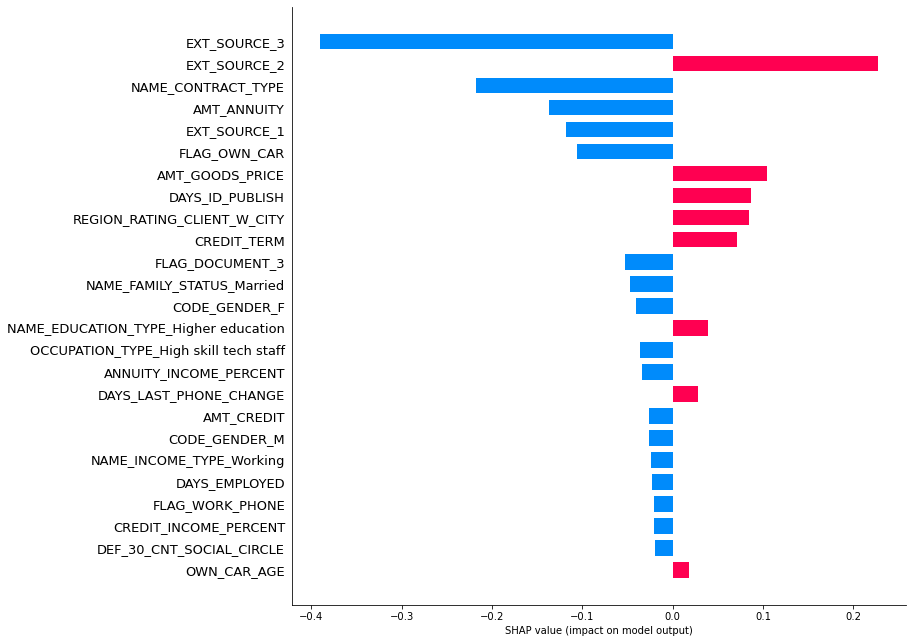

In [139]:
plt.figure(figsize = (11, 11))
shap.bar_plot(explainer.shap_values(X2_test_domain[0]),
              feature_names=domain_features_names,
              max_display=25)

### Comparaison avec LogisticRegression

In [126]:
#X2_test_domain, y2_test_domain
log_reg1 = LogisticRegression(C=1000)
log_reg1.fit(X2_train_domain, y2_train_domain)
log_reg_explainer1 = shap.LinearExplainer(log_reg1, X2_test_domain)

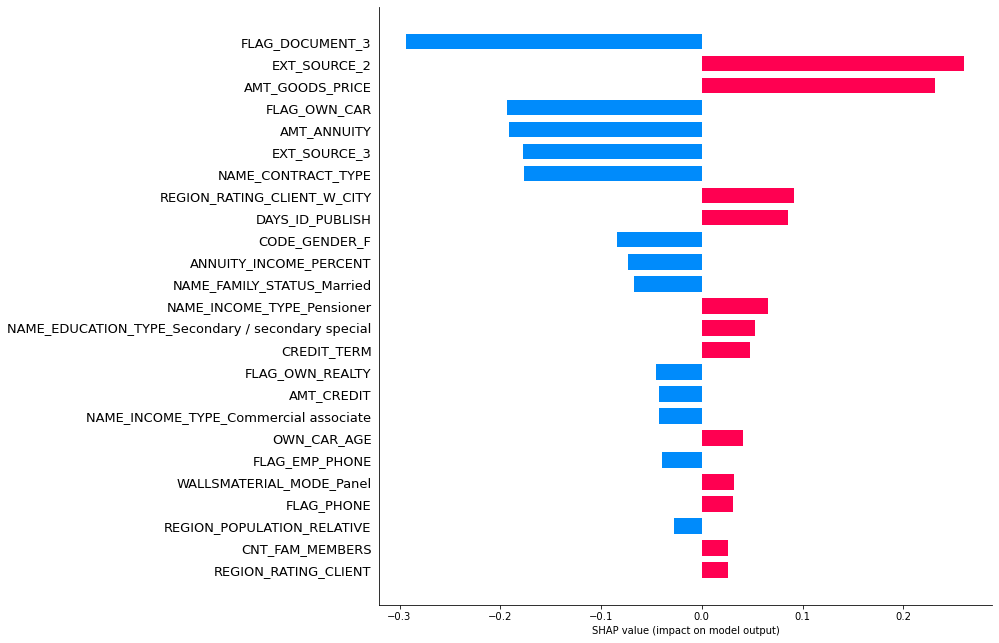

In [127]:
plt.figure(figsize = (11, 11))
shap.bar_plot(log_reg_explainer1.shap_values(X2_test_domain[0]),
              feature_names=domain_features_names,
              max_display=25)

# Annexe et Codes brouillon

In [ ]:

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.85, test_size=0.15, random_state=123, shuffle=True)

#print("Train/Test Sizes : ",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

#lin_reg = LinearRegression()
#lin_reg.fit(X_train, Y_train)

#lin_reg_explainer1 = shap.LinearExplainer(lin_reg, X_train)

# The SHAP Values
#import shap
#explainer = shap.Explainer(xgb_model)
#shap_values = explainer(X_test)

#X2_train_domain, X2_test_domain, y2_train_domain, y2_test_domain 

In [271]:
# Modéle avec les hyperparamétres
#log_reg = LogisticRegression() # learning modéle de LogisticRegression
#log_reg.fit(Xsmall_train, ysmall_train)

#param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} # nos best paramétre pour le modéle

#log_grid1=GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc')# pour faire appel au modéle
#log_grid.fit(Xsmall_train, ysmall_train)

In [280]:
#X2_test_domain, y2_test_domain
#log_grid1.fit(X2_train_domain, y2_train_domain)
#log_reg_explainer1 = shap.LinearExplainer(log_grid1, X2_test_domain)

In [259]:
#log_reg1 = LogisticRegression()
#log_reg_explainer1 = shap.LinearExplainer(log_reg)

In [ ]:
#plt.figure(figsize = (20, 20))
#shap.bar_plot(log_reg_explainer1.shap_values(X2_test_domain[0]),
#              feature_names=domain_features_names,
#              max_display=len(domain_features_names))